# Solve optimal control for constrained diffusion process.
Uncontrolled process: $$dX_s = \Big[-\mu(X_s, s) + \sigma(s)^\top \sigma(s) \cdot \nabla_x \log p(X_s, s) \Big] ds + \sigma(s) \cdot dB_s, \quad X_0 \sim p_0 = \mathcal{N}(0, \mathbf{I}), \quad X_T \sim p_{data} $$
Controlled process: $$dX^u_s = \Big[-\mu(X^u_s, s) + \sigma(s)^\top \sigma(s) \cdot \big[\nabla_x \log p(X_s, s) - \nabla_x V(X_s, s) \big] \Big] ds + \sigma(s) \cdot dB_s, \quad X_0 \sim p_0 = \mathcal{N}(0, \mathbf{I})$$

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device; ', device)

FIG_ROWSIZE = 6
FIG_COLSIZE = 6
FIG_FONTSIZE = 14
SCATTER_POINT_SIZE = 5.0

device;  cuda:0


## Load swiss-roll dataset.

delta_x:  33.314197004642125


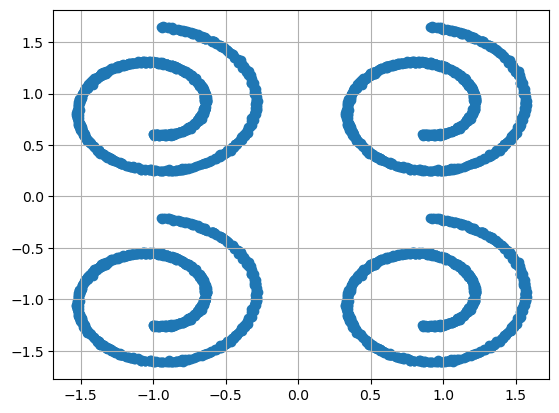

In [2]:
from sklearn.datasets import make_swiss_roll

MULTI_SWISSROLL = True
MODEL = 'ConditionalLinear'
beta_schedule = 'linear'
DIFFUSION_STEPS = 200
MODEL_LOAD_PATH = f'models/{MODEL}_T_{DIFFUSION_STEPS}_beta_{beta_schedule}.pt'
CONTROLLER_LOAD_PATH = None
N_SAMPLES = 1000 # 100000

x, _ = make_swiss_roll(n_samples=N_SAMPLES, noise=0.1)
# Make two-dimensional to easen visualization
x = x[:, [0, 2]]

# x = (x - x.mean()) / x.std()

if MULTI_SWISSROLL:
    delta_x = 5 * x.std()
    print('delta_x: ', delta_x)

    x_rshift = x + np.tile([delta_x, 0], reps=(x.shape[0], 1))
    x_upshift = x + np.tile([0, delta_x], reps=(x.shape[0], 1))
    x_rupshift = x + np.tile([delta_x, delta_x], reps=(x.shape[0], 1))

    x = np.concatenate((x, x_rshift, x_upshift, x_rupshift), axis = 0)

x = (x - x.mean()) / x.std()
np.random.shuffle(x)

plt.grid(which='major')
plt.scatter(x[:, 0], x[:, 1])

X = torch.tensor(x, dtype=torch.float32).to(device)

## Create a VP-SDE object for the uncontrolled process

In [3]:
from core.sde import VPSDE

diffusion_steps = DIFFUSION_STEPS  # Number of steps in the diffusion process

beta_min = 0.1
beta_max = 20
betas = torch.linspace(beta_min / diffusion_steps, beta_max / diffusion_steps, diffusion_steps).to(device=device)

alphas = 1 - betas
baralphas = torch.cumprod(alphas, dim = 0)

sde = VPSDE(N=diffusion_steps, beta_min = beta_min, beta_max = beta_max, beta_schedule='linear', device=device)

## Diffusion Network

Now we define a pytorch network that will learn to predict the noise component from noised data.

In [4]:
import torch.nn as nn


## Unconditional FCNN diffusion model
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
    
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val
    

## Conditional Linear diffusion model
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x: torch.Tensor, y: torch.Tensor):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out # t + Graph

        out = F.softplus(out)
        return out
    
        
class ConditionalLinearModel(nn.Module):
    def __init__(self, nsteps, nfeatures: int, nblocks: int = 2, nunits: int = 128):
        super(ConditionalLinearModel, self).__init__()
        self.nsteps = nsteps
        self.inblock = ConditionalLinear(nfeatures, nunits, nsteps)
        # self.lin2 = ConditionalLinear(128, 128, nsteps)
        # self.lin3 = ConditionalLinear(128, 128, nsteps)
        self.midblock = nn.ModuleList([ConditionalLinear(nunits, nunits, nsteps) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor,
                edge_index = None, edge_weight = None, transmitters_index = None):
        val = self.inblock(x, t)
        for midblock in self.midblock:
            val = midblock(val, t)
        val = self.outblock(val)
        return val

Load a pre-trained diffusion model.

In [5]:
if MODEL == 'FCNN':
    nblocks = 6 if MULTI_SWISSROLL else 4
    nunits = 64
    model = DiffusionModel(nfeatures=2, nblocks=nblocks, nunits = nunits)

elif MODEL == 'ConditionalLinear':
    nblocks = 6 if MULTI_SWISSROLL else 4
    nunits = 128
    model = ConditionalLinearModel(nsteps=diffusion_steps, nfeatures=2, nblocks=nblocks, nunits=nunits)
else:
    raise NotImplementedError

MODEL_TRAINED = False
if MODEL_LOAD_PATH is not None:
    try:
        model.load_state_dict(torch.load(MODEL_LOAD_PATH))
        print(f'Loading pretrained model weights from {MODEL_LOAD_PATH} is successful.')
        MODEL_TRAINED = True

    except:
        print(f'Could not load model state dict from {MODEL_LOAD_PATH}! Training model from scratch.')
        raise ModuleNotFoundError

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Loading pretrained model weights from models/ConditionalLinear_T_200_beta_linear.pt is successful.


Visualize the learned score field.

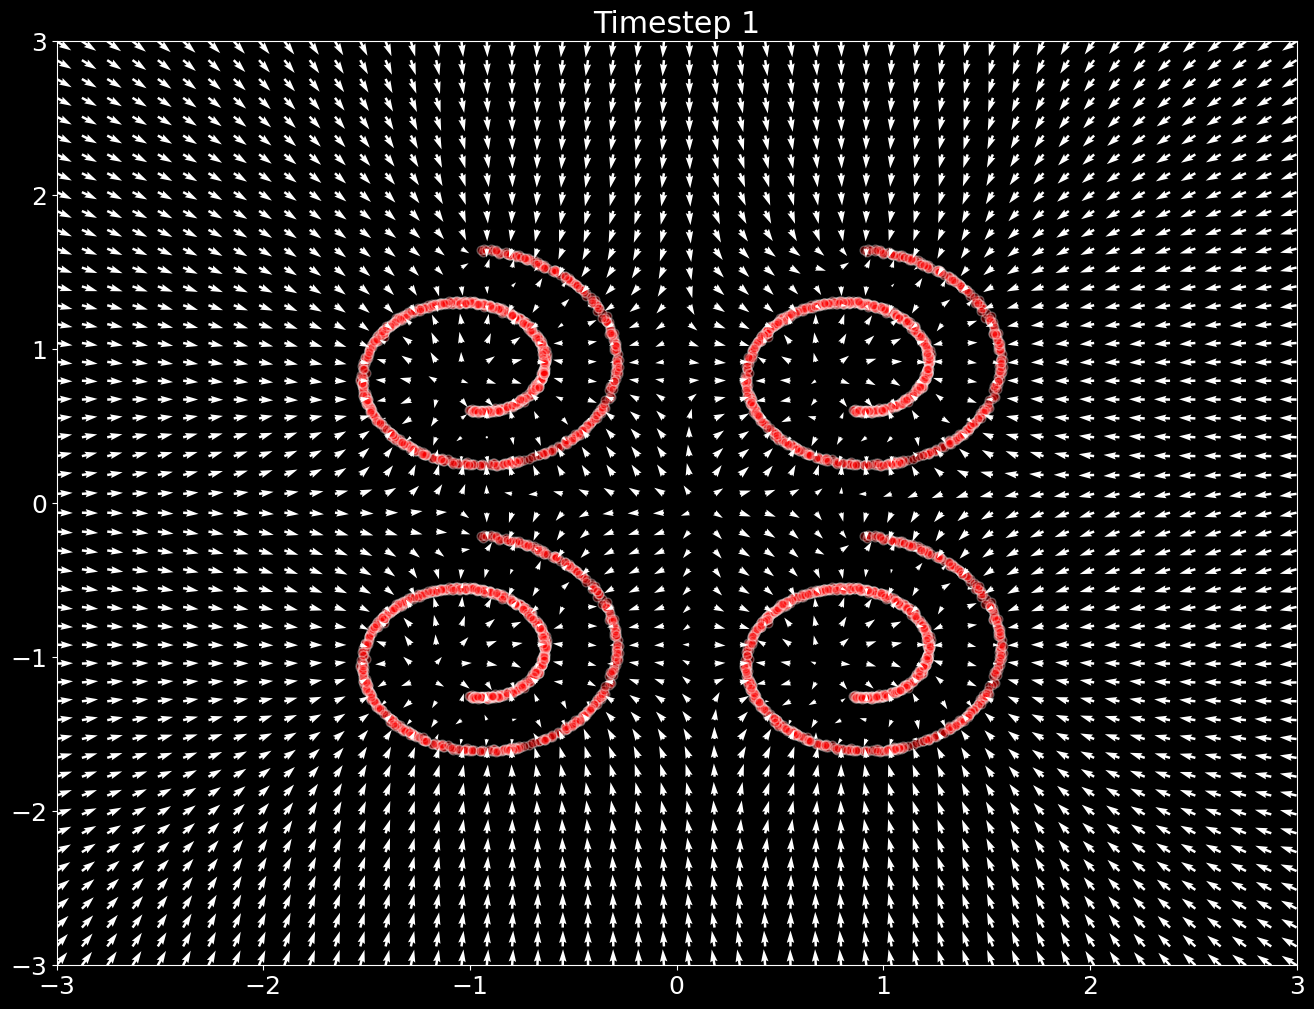

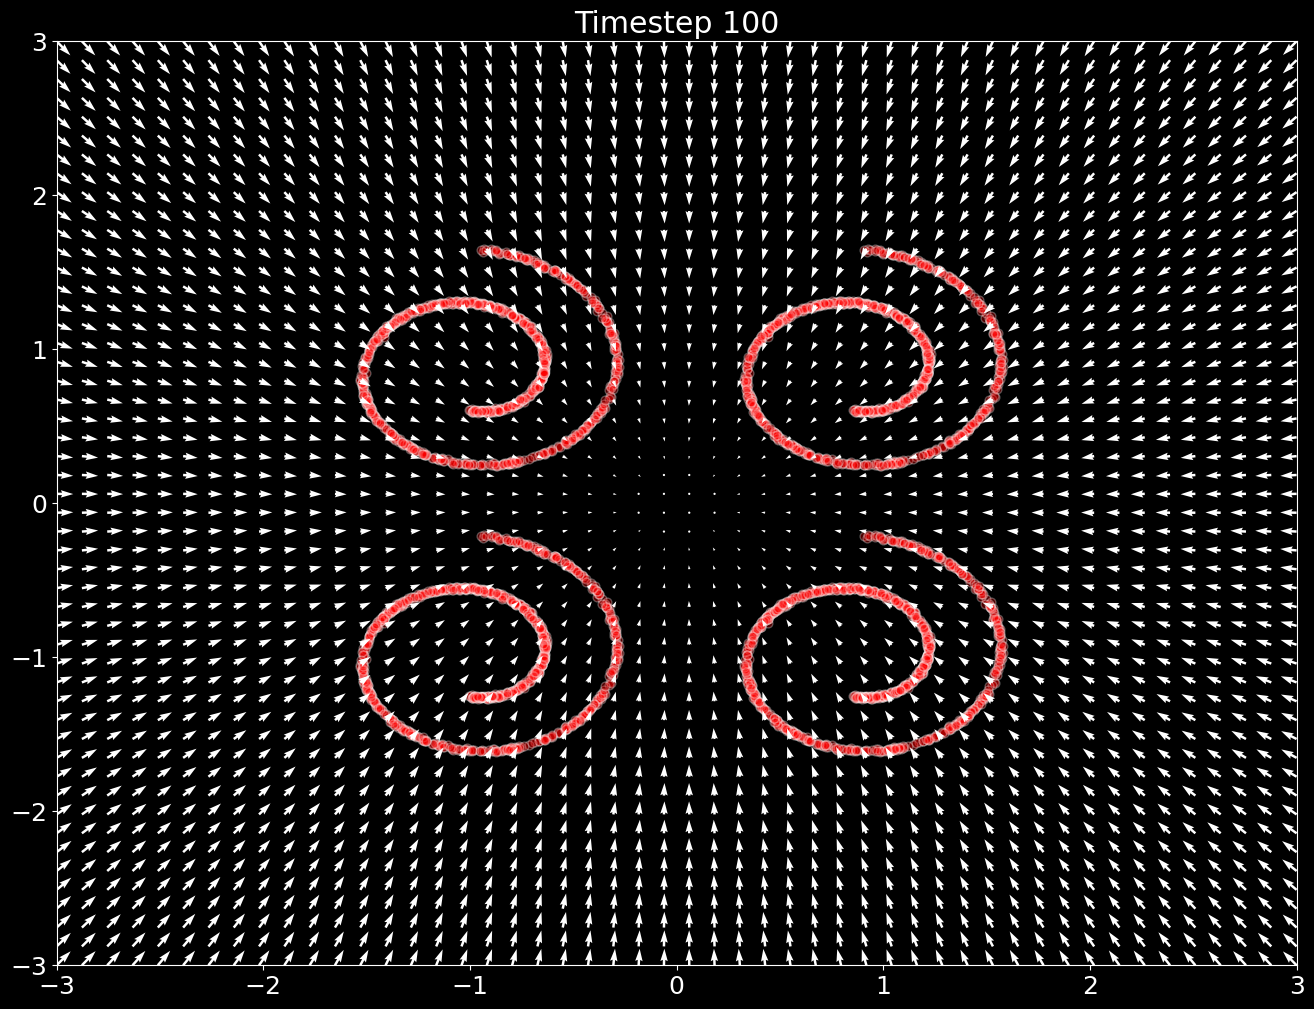

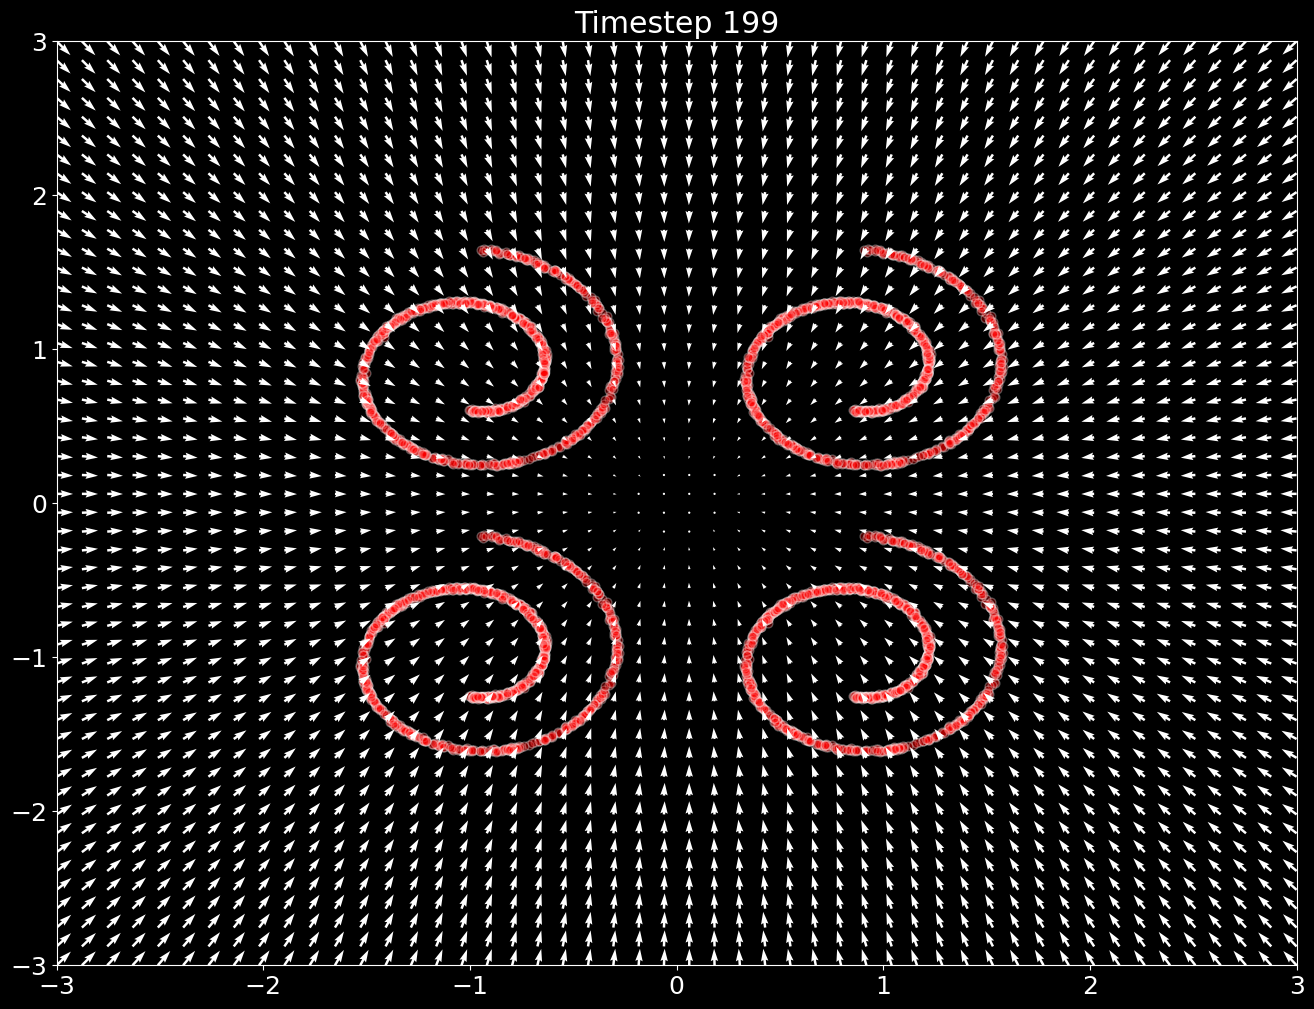

In [6]:
from utils.helper_plot import hdr_plot_style
hdr_plot_style()


def make_score_model(sde, noise_model, controller = None, accel_factor = 1, DEBUG = False):
    def score_fn(x, t):
        # timestep = sde.timestep(t)
        if torch.is_floating_point(t): # cts time
            timestep = sde.timestep(t).to(torch.long)
            if DEBUG:
                print(f'Mapped cts time {t} to discrete time {timestep}.')
        else:
            timestep = t.to(torch.long)
        model_timestep = timestep / (sde.N - 1) * (accel_factor * sde.N - 1)
        noise_pred = noise_model(x, model_timestep.to(torch.long))
        score, _ = sde.score_fnc_to_noise_pred(timestep=timestep, score=None, noise_pred=noise_pred)

        if controller is not None:
            u = controller(x, timestep)
            score = score - u / torch.sqrt(sde.discrete_betas[timestep])
        
        return score
    
    return score_fn


def make_noise_model(sde, noise_model, accel_factor = 1, DEBUG = False):
    def noise_fn(x, t):
        # timestep = sde.timestep(t)
        if torch.is_floating_point(t): # cts time
            timestep = sde.timestep(t).to(torch.long)
            if DEBUG:
                print(f'Mapped cts time {t} to discrete time {timestep}.')
        else:
            timestep = t.to(torch.long)
        model_timestep = timestep / (sde.N - 1) * (accel_factor * sde.N - 1)
        noise_pred = noise_model(x, model_timestep.to(torch.long))
        
        return noise_pred
    
    return noise_fn


def plot_gradients(model, data, plot_scatter=True, plot_timestep = 1, is_noise_model = False, axs = None):
    timestep = plot_timestep
    xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)

    scores = model(torch.tensor(xx).float().to(device), timestep/(DIFFUSION_STEPS-1) * torch.ones(size = (xx.shape[0], 1)).to(device)).detach().cpu()
    if is_noise_model:
        scores = (-1/(1 - baralphas[timestep])**0.5 * scores).detach().cpu()
    
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    if axs is None:
        # Perform the plots
        plt.figure(figsize=(16,12))
        if (plot_scatter):
            plt.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
        plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.title(f'Timestep {timestep}')

    else:
        if (plot_scatter):
            axs.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
        axs.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
        axs.set_xlim(-3, 3)
        axs.set_ylim(-3, 3)
        axs.set_title(f'Timestep {timestep}')


# def plot_gradients_v2(score_model, data, plot_scatter=True, plot_timestep = 1):
#     timestep = plot_timestep
#     xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
#     scores = score_model(torch.tensor(xx).float().to(device), timestep/(DIFFUSION_STEPS-1) * torch.ones(size = (xx.shape[0], 1)).to(device)).detach().cpu()
#     scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
#     scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
#     # Perform the plots
#     plt.figure(figsize=(16,12))
#     if (plot_scatter):
#         plt.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
#     plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)

score_model = make_score_model(sde=sde, noise_model=model, accel_factor=1, DEBUG = False)

for t in range(1, DIFFUSION_STEPS, 99):
    plot_gradients(score_model, X.cpu(), plot_timestep=t, is_noise_model=False)


# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Sample via annealed Langevin dynamics.

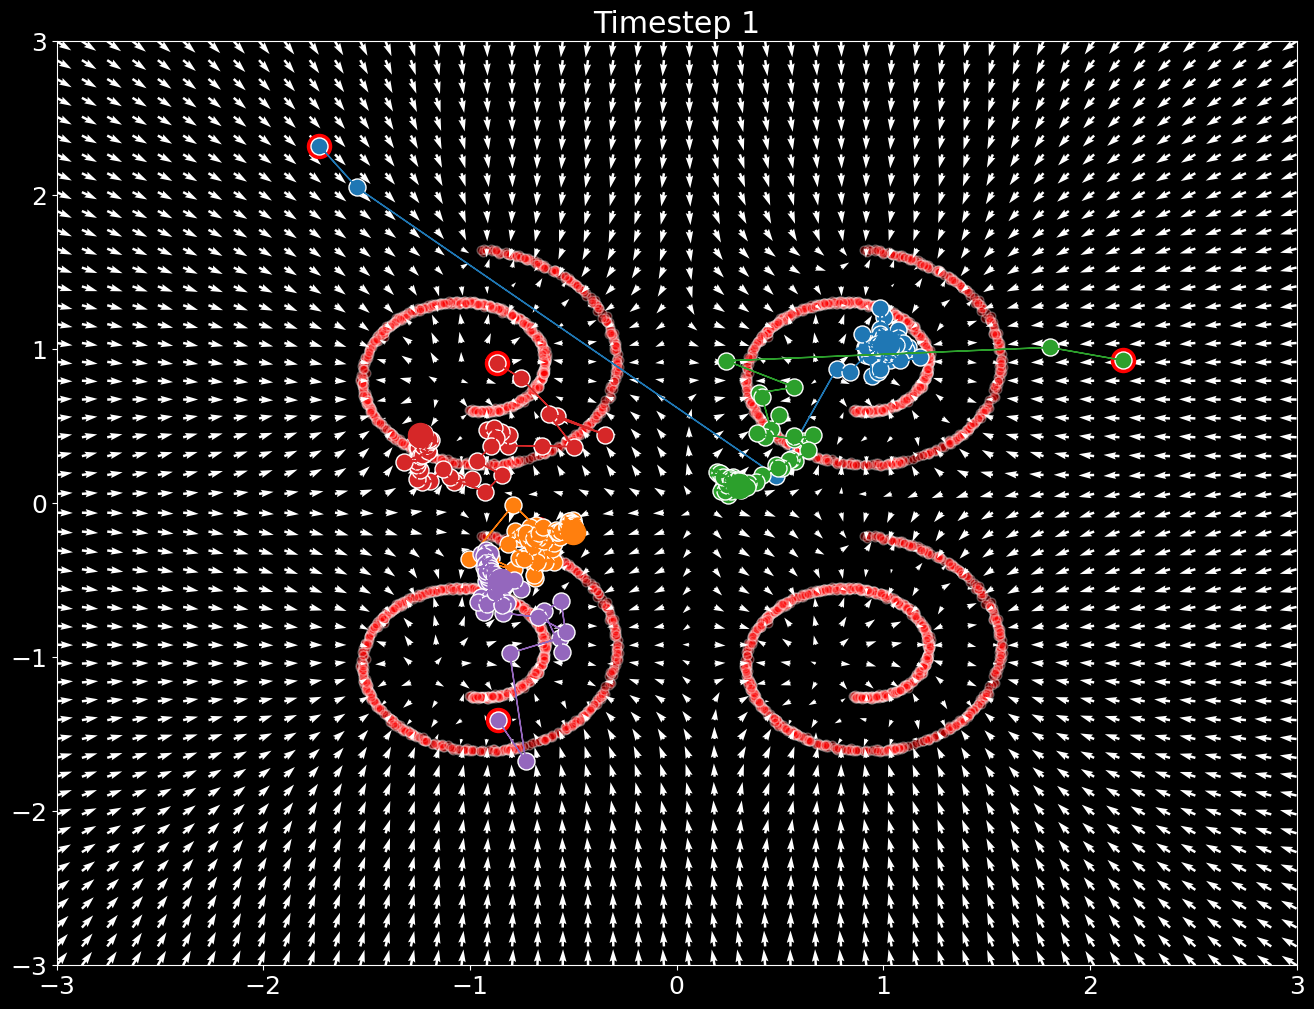

In [7]:
def sample_simple(score_model, x, n_steps=100, eps=1e-1, sample_timestep = 1, decay = .9, temperature = 1.):
    x_sequence = [x]

    timesteps = [sample_timestep] * n_steps if not isinstance(sample_timestep, list) else sample_timestep
    for s in range(n_steps):
        z = torch.randn_like(x)
        # noise_pred = noise_model(x.to(device), torch.ones((x.shape[0], 1)).to(device))
        score = score_model(x.to(device), s / (DIFFUSION_STEPS - 1) * torch.ones((x.shape[0], 1)).to(device)).detach().cpu()
        # score = (x.to(device) * (1 / baralphas[timesteps[s]]**0.5 - 1) - (1 / baralphas[timesteps[s]] - 1)**0.5 * noise_pred).detach().cpu()

        # score = (-1/(1 - baralphas[timesteps[s]])**0.5 * noise_pred).detach().cpu()
        # print('score: ', score.shape, '\tx: ', x.shape)
        x = x + eps/2 * score + eps**0.5 * temperature * z
        x_sequence.append(x)

        eps *= decay
    return torch.cat(x_sequence)


# x = torch.Tensor([2, -2]).unsqueeze(0)
x = 6 * torch.rand((5, 2)) - 3

hdr_plot_style()
fig, axs = plt.subplots(1, 1, figsize = (16, 12))
plot_gradients(score_model, X.cpu(), is_noise_model=False, axs = axs)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

hdr_plot_style()
for sample_id in range(x.shape[0]):
# samples = sample_simple(score_model, x).detach()

    samples = sample_simple(score_model=score_model,
                            x=x[sample_id].unsqueeze(0),
                            n_steps = 100,
                            eps=2e-2
                            ).detach()

    axs.scatter(x[sample_id][0], x[sample_id][1], color = 'red', edgecolor = 'red', s = 300)

    axs.scatter(samples[:, 0], samples[:, 1], color=cycle[sample_id], edgecolor='white', s=150)
    # draw arrows for each  step
    deltas = (samples[1:] - samples[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        axs.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=1e-2, color=cycle[sample_id], linewidth=1)

    axs.scatter(samples[-1, 0], samples[-1, 1], color = cycle[sample_id], edgecolor = cycle[sample_id], s = 300)

# plt.legend(loc = 'best')
plt.show()

# for sample_id in range(x.shape[0]):
# # samples = sample_simple(score_model, x).detach()
#     samples = sample_simple(score_model, x[sample_id].unsqueeze(0), n_steps = 100, eps = 1e-1).detach()

#     plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
#     # draw arrows for each  step
#     deltas = (samples[1:] - samples[:-1])
#     deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
#     for i, arrow in enumerate(deltas):
#         plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color=cycle[sample_id], linewidth=3)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Implement controlled SDE simulator.

In [26]:
# def make_controller(sde, lambda_star):

#     def controller(x, t):
#         u_star = u_true(sde=sde, x=x, t=t, lambda_star=lambda_star)
#         return u_star
    
#     return controller


def forward(sde, x_0, t_0 = None, t_1 = None, controller = None, gamma = 1., no_sde_drift = False, is_backward = False, verbose = False):
    """ Simulate discretized SDE with optional control input from cts time \tau = t_0 until \tau = t_1. """
    dt = 1 / (sde.N - 1)
    if t_0 is None:
        t_0 = torch.ones_like(x_0)[:, 0:1] if is_backward else torch.zeros_like(x_0)[:, 0:1]
    else:
        t_0 = t_0

    t_1 = 1 - t_0 if t_1 is None else t_1
    dt = -dt if is_backward else dt

    with torch.no_grad():
        xt = [x_0.detach().cpu()]
        tt = [t_0.detach().cpu()]
        zt = [[None]]
        ut = [[None]]

        x = x_0.clone()
        t = t_0.clone()
        
        if is_backward:
            while torch.any(t > t_1):
                if verbose:
                    print('Reverse process timestep: ', sde.timestep(t[0]))

                rev_f, rev_G = sde.discretize(x, t) # G = \sigma_t * sqrt(dt)

                # beta_t = sde.beta_0 + t * (sde.beta_1 - sde.beta_0) # linear SDE
                # sigma_t = torch.sqrt(beta_t)

                f = 0 if no_sde_drift else -rev_f
                G = rev_G

                with torch.set_grad_enabled(True):
                    if controller is not None:
                        u = controller(x, t)
                        u[torch.isnan(u)] = 0.
                        # f = f + gamma * G**2  * u # control is already added
                    else:
                        u = None

                z = torch.randn_like(x)
                x = x + (t > t_1) * (f + G * z)
                t = t + (t > t_1) * dt

                xt += [x.detach().cpu()]
                tt += [t.detach().cpu()]
                zt += [z.detach().cpu()]
                if controller is not None:
                    ut += [u.detach().cpu()]

        else:
            while torch.any(t < t_1):
                if verbose:
                    print('Forward process timestep: ', sde.timestep(t[0]))
                f, G = sde.discretize(x, t) # G = \sigma_t * sqrt(dt)

                beta_t = sde.beta_0 + t * (sde.beta_1 - sde.beta_0) # linear SDE
                sigma_t = torch.sqrt(beta_t)

                f = 0 if no_sde_drift else f

                # timestep = (t / (sde.N - 1)).to(torch.long)
                # betas = sde.discrete_betas[timestep]
                # sigma_t = torch.sqrt(betas)

                with torch.set_grad_enabled(True):
                    if controller is not None:
                        u = controller(x, t)
                        u[torch.isnan(u)] = 0.
                        # f = f + gamma * (G / dt**0.5) * u * dt
                        f = f + gamma * G**2  * u
                    else:
                        u = None

                z = torch.randn_like(x)
                x = x + (t < t_1) * (f + G * z)
                t = t + (t < t_1) * dt

                xt += [x.detach().cpu()]
                tt += [t.detach().cpu()]
                zt += [z.detach().cpu()]
                if controller is not None:
                    ut += [u.detach().cpu()]

        if controller is not None:
            return xt, (tt, ut, zt)
        else:
            return xt, (tt, zt)
        

BACKWARD = True
timesteps = torch.randint(low = 0, high = sde.N - 1, size = (X.shape[0], 1), device = device)
t = timesteps / (sde.N - 1)
    
if BACKWARD:
    t = torch.ones_like(t) 
    X_0 = sde.prior_sampling(X.shape)
    controller = score_model
    diffusion_sde = sde.reverse(score_fn=controller)

else:
    t = torch.zeros_like(t) 
    X_0 = X
    controller = None
    diffusion_sde = sde

# t = torch.full([X.shape[0], 1], 50/(sde.N-1)).to(device)
# t = torch.randint(low = 0, high=sde.N-1, size = t.size(), device = t.device) / sde.N-1

Xgen_hist, Tgen_hist = forward(sde=diffusion_sde, x_0=X_0, t_0=t, controller=controller, gamma=1, is_backward=BACKWARD)
# controller = make_controller(sde=sde, lambda_star=lambda_star)
# Xgen_controlled_hist, Tgen_controlled_hist = forward(sde=sde, x_0=X, t_0=t, controller=controller, gamma=1)   

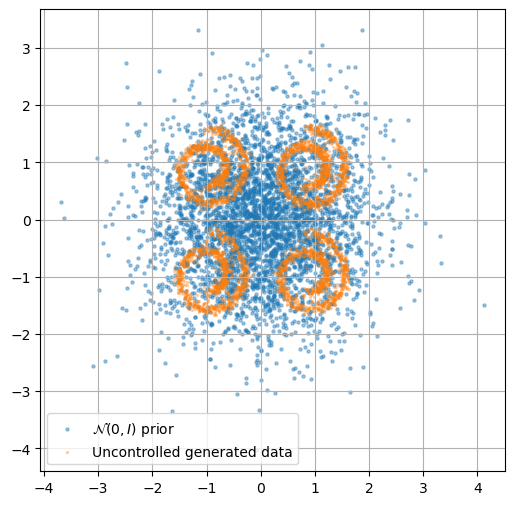

In [9]:
fig, axs = plt.subplots(1, 1, figsize = (1 * FIG_COLSIZE, 1 * FIG_ROWSIZE))

axs.scatter(X_0[:, 0].cpu(), X_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.4, label = r'$\mathcal{N}(0, I)$ prior' if BACKWARD else 'Original data')
axs.scatter(Xgen_hist[-1][:, 0].cpu(), Xgen_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.4, label = 'Uncontrolled generated data')

# axs[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
# axs.scatter(Xgen_controlled_hist[-1][:, 0].cpu(), Xgen_controlled_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Controlled generated data')

axs.grid(True)
axs.legend(loc = 'best')

plt.show()

## Constrained Diffusion: Define constraints

Define terminal constraints.

dom_boundary_low:  [-inf, -inf]
dom_boundary_high:  [0.0, 0.0]


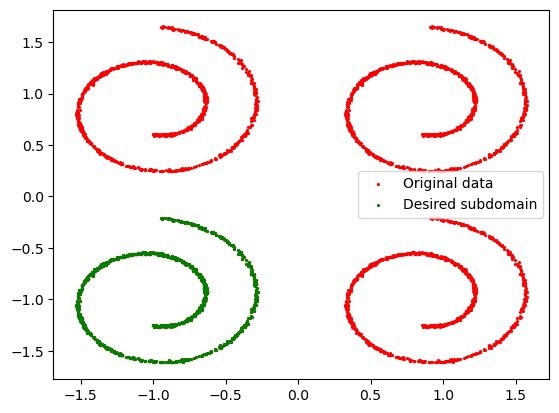

100%|██████████| 1/1 [00:00<00:00, 1886.78it/s]


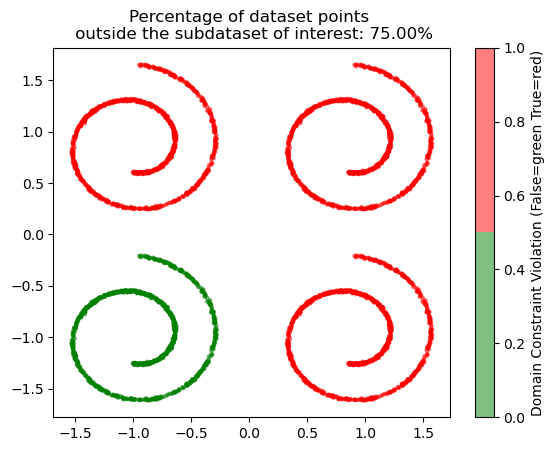

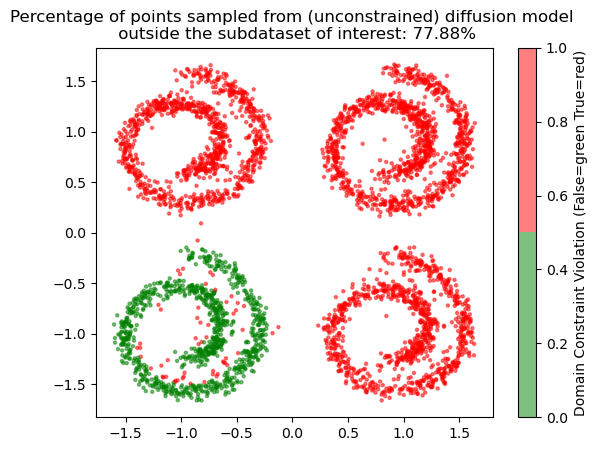

In [10]:
from matplotlib.colors import ListedColormap

color_true = 'red'
color_false = 'green'

def my_indicator_fnc(value, thresh):
    '''
    Implements the differentiable indicator function I(value > thresh).
    '''
    soft_indicator = torch.sigmoid(value - thresh)
    indicator = (value > thresh).float() - soft_indicator.detach() + soft_indicator
    return indicator, soft_indicator 


def make_constraint_fnc(eval_type, rhs, dom_boundary_low = None, dom_boundary_high = None):

    dom_boundary_low = [-float("Inf"), -float("Inf")] if dom_boundary_low is None else dom_boundary_low
    dom_boundary_high = [float("Inf"), float("Inf")] if dom_boundary_high is None else dom_boundary_high

    if eval_type == 'linear':
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            mean = Xbatch - c
            return mean
        
    elif eval_type == 'quadratic':
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            variance = (Xbatch - Xbatch.mean(dim = 0, keepdim = True))**2 - c
            return variance
        
    elif eval_type == 'pinned-measure':
        # X > c entries across individual dimensions
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)

            # dom_boundary = torch.tensor([.5, -1]).repeat(Xbatch.shape[0], 1)
            dom_boundary_low = torch.tensor(dom_boundary_low).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            dom_boundary_high = torch.tensor(dom_boundary_high).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            # dom_boundary = torch.tensor([.5, .5]).repeat(Xbatch.shape[0], 1)
            
            ind_low, soft_ind_low = my_indicator_fnc(value=-Xbatch, thresh=-dom_boundary_low)
            ind_high, soft_ind_high = my_indicator_fnc(value=Xbatch, thresh=dom_boundary_high)
            ind = torch.stack([ind_low, ind_high], dim = -1)
            soft_ind = torch.stack([soft_ind_low, soft_ind_high], dim = -1)

            ind = torch.any(ind.bool(), dim = -1, keepdim=False) * 1.
            soft_ind = 1 - torch.prod((1 - soft_ind), dim = -1, keepdim=False)
            
            return ind - c
        
    elif eval_type == 'pinned-measure-single-lambda':
        # X > c entries across all dimensions
        print('dom_boundary_low: ', dom_boundary_low)
        print('dom_boundary_high: ', dom_boundary_high)
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            # dom_boundary = torch.tensor([.5, -1]).repeat(Xbatch.shape[0], 1)
            db_low = torch.tensor(dom_boundary_low).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            db_high = torch.tensor(dom_boundary_high).repeat(Xbatch.shape[0], 1).to(Xbatch.device)

            # dom_boundary = torch.tensor([.5, .5]).repeat(Xbatch.shape[0], 1)

            ind_low, soft_ind_low = my_indicator_fnc(value=-Xbatch, thresh=-db_low)
            ind_high, soft_ind_high = my_indicator_fnc(value=Xbatch, thresh=db_high)

            ind = torch.cat([ind_low, ind_high], dim = -1)
            soft_ind = torch.cat([soft_ind_low, soft_ind_high], dim = -1)

            ind = torch.any(ind.bool(), dim = -1, keepdim=True) * 1.
            soft_ind = 1 - torch.prod((1 - soft_ind), dim = -1, keepdim=True)

            return ind - c
        
    else:
        raise NotImplementedError

    return constraint_fnc


def make_loss_fn(X, method = 'avg-cdist', cdist_thresh = 0.1, DEBUG = False):
    if method == 'avg-cdist':
        def loss_fn(point):
            dist = torch.cdist(x1 = point, x2 = X, p=2).mean(dim = -1, keepdim = True)
            return dist, None
        
    elif method == 'min-cdist':
        def loss_fn(point):
            dist = torch.cdist(x1 = point, x2 = X, p=2).amin(dim = -1, keepdim = True)
            return dist, None
        
    elif method == 'indicator-avg-cdist':
        def loss_fn(point):
            dist = torch.cdist(x1 = point, x2 = X, p=2).mean(dim = -1, keepdim = True)
            loss, soft_loss = my_indicator_fnc(value=(dist - cdist_thresh) / 1, thresh=0)
            return loss, soft_loss
        
    elif method == 'indicator-min-cdist':
        def loss_fn(point):
            if DEBUG:
                print(f'x1.shape: {point.shape}, x2.shape: {X.shape}')
            dist = torch.cdist(x1 = point, x2 = X, p=2).amin(dim = -1, keepdim = True)
            loss, soft_loss = my_indicator_fnc(value=(dist - cdist_thresh) / 0.2, thresh=0)
            return loss, soft_loss
        
    return loss_fn


def scatter_plot_with_binary_colormap(X, labels, colors = ['green', 'red']):
    colormap = ListedColormap(colors)
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, c = labels, cmap = colormap, alpha = 0.5)


dom_boundary_high = [0.0, 0.0] # [0., 0.]

dom_ind_func = make_constraint_fnc(eval_type='pinned-measure-single-lambda', rhs=0, dom_boundary_high=dom_boundary_high)
dom_ind = torch.logical_not(dom_ind_func(Xbatch=X).bool()).squeeze(-1)

plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, marker = '1', c = 'r', label = 'Original data')
plt.scatter(X[dom_ind][:, 0].cpu(), X[dom_ind][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker = '1', c = 'g', label = 'Desired subdomain')
plt.legend(loc = 'best')
plt.show()


loss_fn = make_loss_fn(X=X[dom_ind], method='indicator-min-cdist', cdist_thresh=0.1)

batch_size = 10000

all_losses = []
all_soft_losses = []
for i in tqdm.tqdm(range(0, X.shape[0], batch_size)):
    loss, soft_loss = loss_fn(X[i:i+batch_size])
    all_losses.append(loss)
    all_soft_losses.append(soft_loss)

loss = torch.cat(all_losses, dim = 0)
soft_loss = torch.cat(all_soft_losses, dim = 0)

colors = loss.detach().cpu().numpy()
# Define custom colormap based on boolean values
colormap = ListedColormap([color_false, color_true])

plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, c = colors, cmap = colormap, alpha = 0.5)

# Create a colorbar to show the mapping from colors to numbers
plt.colorbar(label='Domain Constraint Violation (False={} True={})'.format(color_false, color_true))

plt.title(f'Percentage of dataset points \n outside the subdataset of interest: { (loss.mean().item() * 100) :.2f}%')
plt.show()


### Check unconstrained diffusion model generations' constraint satisfaction ###
loss, _ = loss_fn(Xgen_hist[-1].to(device))

colors = loss.detach().cpu().numpy()
# Define custom colormap based on boolean values
colormap = ListedColormap([color_false, color_true])

plt.scatter(Xgen_hist[-1][:, 0].cpu(), Xgen_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, c = colors, cmap = colormap, alpha = 0.5)

# Create a colorbar to show the mapping from colors to numbers
plt.colorbar(label='Domain Constraint Violation (False={} True={})'.format(color_false, color_true))

plt.title(f'Percentage of points sampled from (unconstrained) diffusion model \n outside the subdataset of interest: { (loss.mean().item() * 100) :.2f}%')
plt.show()

Compute optimal dual multipliers and associated RN density.

In [11]:
def get_train_optimal_lambdas_settings(eval_type):
    '''
    Retrieve training hyperparameters for finding optimal dual multipliers. 
    '''

    settings = {}
    if eval_type in ['linear']:
        settings['lr'] = 2e-1
        settings['niters'] = 200

    elif eval_type in ['abs-linear']:
        settings['lr'] = 5.
        settings['niters'] = 500

    elif eval_type == 'quadratic':
        settings['lr'] = 5e-1
        settings['niters'] = 200

    elif eval_type in ['pinned-measure', 'pinned-measure-single-lambda']:
        settings['lr'] = 5. # 1
        settings['niters'] = 300 # 500

    else:
        raise NotImplementedError

    return settings


def train_optimal_lambdas(lambdas_init, constraints, x_0, niters = 100, lr=1e-1, DEBUG = False, sgd_temperature = 1., sgd_temperature_decay = 0.99):
    '''
    Training loop to find the optimal dual multipliers and the associated change of measure. 
    '''

    lambdas = lambdas_init.clone().requires_grad_(True)
    all_lambdas = []
    all_dQ_star_div_dP = []
    all_Q_star_constraints = []

    with torch.no_grad():
        dQ_star_div_dP = optimal_change_of_measure(lambdas_star=lambdas, constraints=constraints, x_0=x_0)
        Q_star_constraints = (constraints(x_0) * dQ_star_div_dP.unsqueeze(-1)).mean(dim = 0)

        all_lambdas.append(lambdas.detach().clone())
        all_dQ_star_div_dP.append(dQ_star_div_dP.detach().clone())
        all_Q_star_constraints.append(Q_star_constraints.detach().clone())

    with torch.set_grad_enabled(True):
        for iter in range(niters):
            loss = (-lambdas * constraints(x_0)).sum(-1).exp().mean(dim = 0)
            loss.backward()

            with torch.no_grad():
                lambdas -= lr * lambdas.grad + sgd_temperature * torch.randn_like(lambdas)
                lambdas.data.clamp_(0)
            lambdas.grad.zero_()

            if (iter + 1) % 20 == 0 and DEBUG:
                print(f'iter: {iter} \t loss: {loss.item()} \t lambdas: {lambdas}')

            with torch.no_grad():
                dQ_star_div_dP = optimal_change_of_measure(lambdas_star=lambdas, constraints=constraints, x_0=x_0)
                Q_star_constraints = (constraints(x_0) * dQ_star_div_dP.unsqueeze(-1)).mean(dim = 0)

                all_lambdas.append(lambdas.detach().clone())
                all_dQ_star_div_dP.append(dQ_star_div_dP.detach().clone())
                all_Q_star_constraints.append(Q_star_constraints.detach().clone())

            sgd_temperature *= sgd_temperature_decay

    return all_lambdas, all_dQ_star_div_dP, all_Q_star_constraints


def optimal_change_of_measure(lambdas_star, constraints, x_0):
    return (-lambdas_star * constraints(x_0)).sum(-1).exp() / (-lambdas_star * constraints(x_0)).sum(-1).exp().mean(dim = 0, keepdim=True)

In [12]:
CONSTRAINT_TYPE = 'pinned-measure-single-lambda'
CONSTRAINT_RHS = [0.02] # Allow up to 2% constraint violation.


# Create constraint func
if CONSTRAINT_TYPE in ['pinned-measure', 'pinned-measure-single-lambda']:
    dom_boundary_low = [-float("Inf"), -float("Inf")]
    dom_boundary_high = [0, 0] # [0, 0]

    dom_ind_func = make_constraint_fnc(eval_type=CONSTRAINT_TYPE,
                                       rhs=0,
                                       dom_boundary_low=dom_boundary_low,
                                       dom_boundary_high=dom_boundary_high
                                       )
    dom_ind = torch.logical_not(dom_ind_func(Xbatch=X).bool()).squeeze(-1)

    print((dom_ind * 1.).mean())

    # temp_constraints = make_loss_fn(X=X[dom_ind], method='indicator-min-cdist', cdist_thresh=0.1, DEBUG = False)
    temp_constraints = make_loss_fn(X=X[dom_ind], method='min-cdist', cdist_thresh=0.1, DEBUG = False)

    def constraints(Xbatch):
        return temp_constraints(Xbatch)[0] - torch.tensor(CONSTRAINT_RHS).to(Xbatch.device)

else:
    constraints = make_constraint_fnc(eval_type=CONSTRAINT_TYPE,
                                      rhs=CONSTRAINT_RHS
                                      )
    
# Initialize lambdas
lambdas = torch.tensor([0.0] * constraints(X).shape[-1]).to(X.device)

# Get training settings.
settings = get_train_optimal_lambdas_settings(eval_type=CONSTRAINT_TYPE)

# Retrieve terminal data distribution for reference (unconstrained) generative process
x_0 = Xgen_hist[-1].to(device)

lambdas_t, dQ_star_div_dP_t, constraints_Q_t = train_optimal_lambdas(lambdas_init=lambdas,
                                                                     constraints=constraints,
                                                                     x_0=x_0,
                                                                     niters=settings['niters'],
                                                                     lr=settings['lr'],
                                                                     DEBUG = True
                                                                     )

dom_boundary_low:  [-inf, -inf]
dom_boundary_high:  [0, 0]
tensor(0.2500, device='cuda:0')
iter: 19 	 loss: 0.22891080379486084 	 lambdas: tensor([4.5302], device='cuda:0', requires_grad=True)
iter: 39 	 loss: 0.23872415721416473 	 lambdas: tensor([2.3984], device='cuda:0', requires_grad=True)
iter: 59 	 loss: 0.27389419078826904 	 lambdas: tensor([2.4491], device='cuda:0', requires_grad=True)
iter: 79 	 loss: 0.22391121089458466 	 lambdas: tensor([4.6509], device='cuda:0', requires_grad=True)
iter: 99 	 loss: 0.21500661969184875 	 lambdas: tensor([6.2799], device='cuda:0', requires_grad=True)
iter: 119 	 loss: 0.20692813396453857 	 lambdas: tensor([9.6400], device='cuda:0', requires_grad=True)
iter: 139 	 loss: 0.20617195963859558 	 lambdas: tensor([9.9961], device='cuda:0', requires_grad=True)
iter: 159 	 loss: 0.2015233188867569 	 lambdas: tensor([11.8592], device='cuda:0', requires_grad=True)
iter: 179 	 loss: 0.20022597908973694 	 lambdas: tensor([12.3655], device='cuda:0', requir

Lambdas_star_hat:  tensor([nan], device='cuda:0')
Nan lambda star
$\mathbb{P}$ constraint slack:  tensor([1.1612], device='cuda:0')
$\mathbb{Q}^\star$ constraint slack:  tensor([0.0100], device='cuda:0')
$\mathbb{P} || \mathbb{Q}^\star KL DIV:  1.4859000444412231
(4000,)


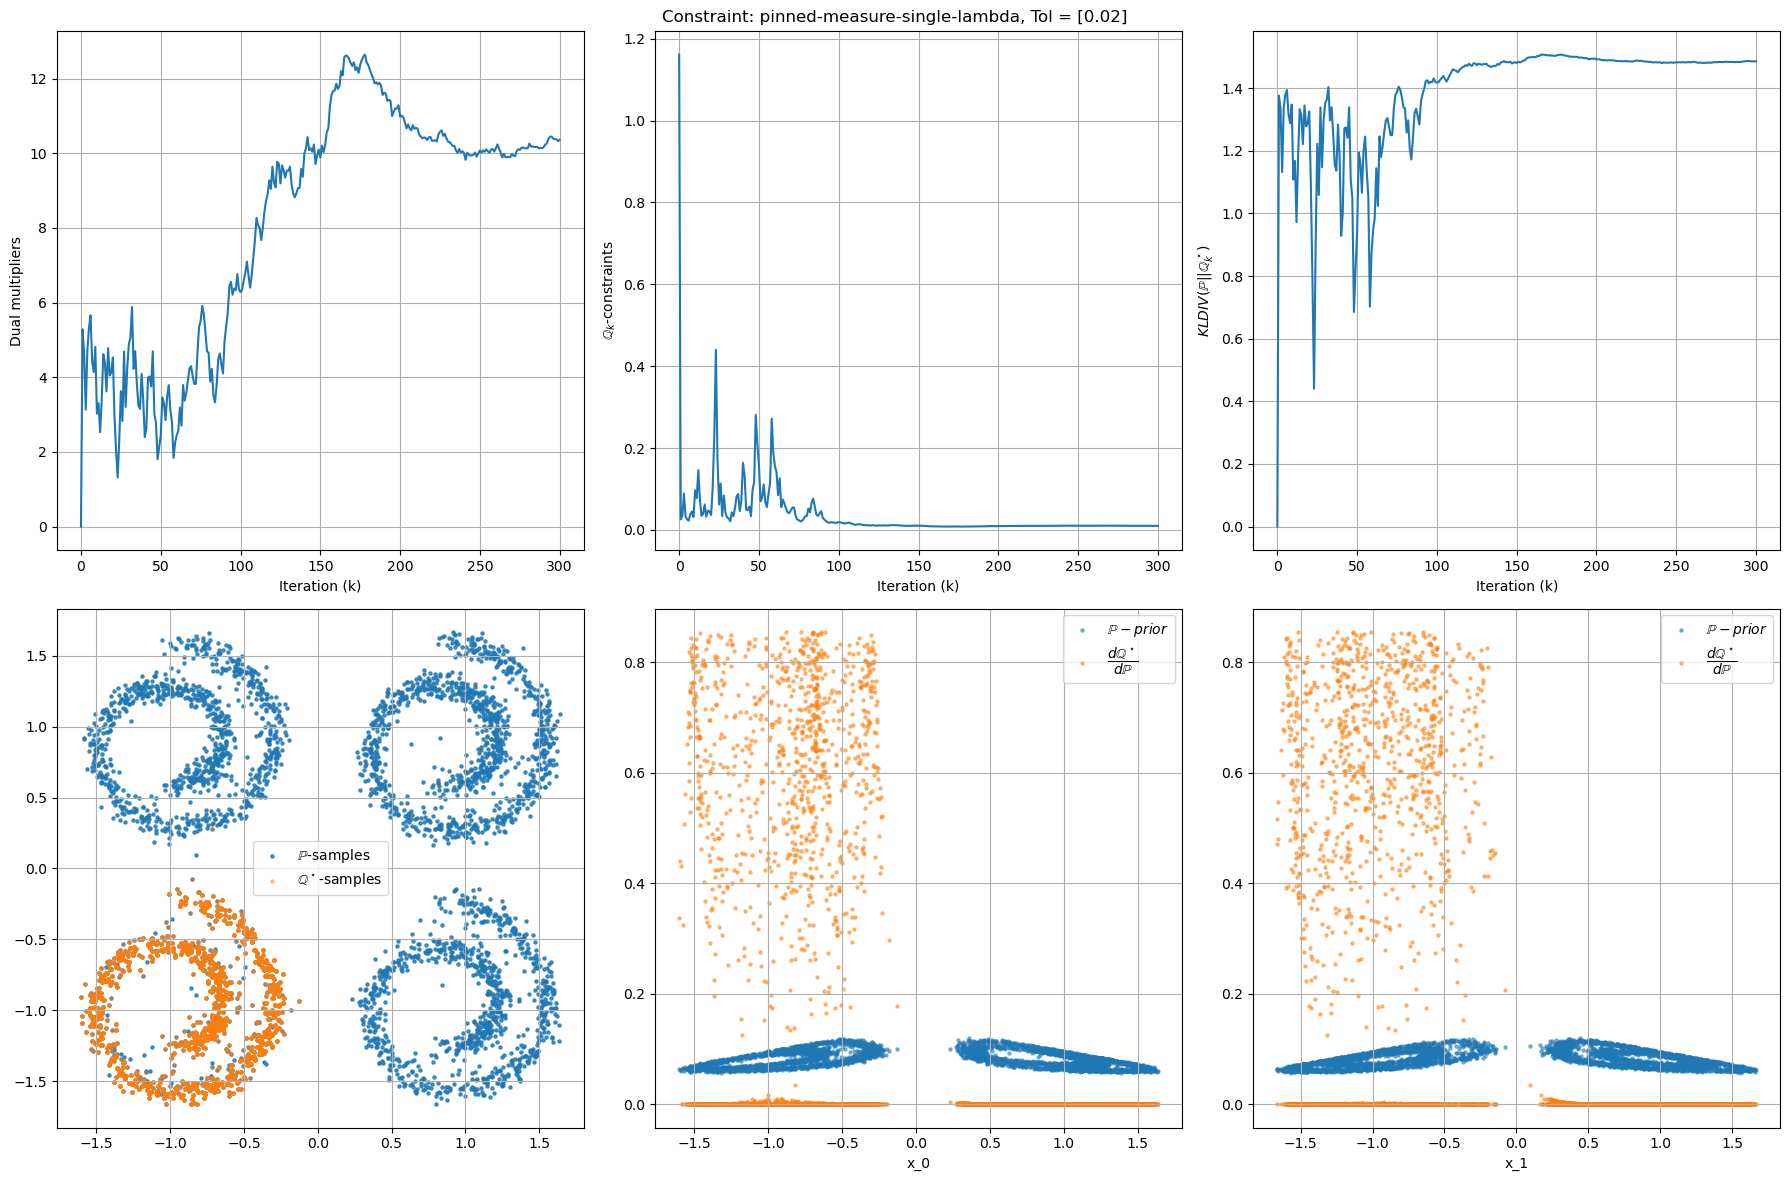

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler

P_constraints = constraints(x_0).mean(dim = 0)
Q_star_constraints = (constraints(x_0) * dQ_star_div_dP_t[-1].unsqueeze(-1)).mean(dim = 0)
KL_DIV = [(dQ_star_div_dP_t[k] * dQ_star_div_dP_t[k].log()).mean().item() for k in range(len(dQ_star_div_dP_t))]
# values = []
# for idx in tqdm.tqdm(range(X_1.shape[0])):
#     value = value_func(x_t=X_1[idx], t=torch.tensor(1), sde=sde, constraints=constraints, lambdas=lambdas, num_trajectories=100)
#     values.append(value.item())

# V_0 = np.mean(values).item()
# print('Expected value function V_0: ', V_0)

if CONSTRAINT_TYPE in ['pinned-measure', 'pinned-measure-single-lambda']:
    q = torch.tensor(CONSTRAINT_RHS).to(device)
    p_D0 = 1 - (q + P_constraints)
    lambdas_star_hat = ((1/p_D0 - 1) * (1/q - 1)).log().data.clamp_(0)

    print('Lambdas_star_hat: ', lambdas_star_hat)


x_0_Q_star_dataset = TensorDataset(x_0)
Q_star_sampler = WeightedRandomSampler(dQ_star_div_dP_t[-1], len(dQ_star_div_dP_t[-1]))
Q_dataloader = torch.utils.data.DataLoader(dataset=x_0_Q_star_dataset,
                                            sampler=Q_star_sampler,
                                            batch_size = 1000,
                                            drop_last = False
                                            )

# print('Dataset length: ', len(x_0_Q_star_dataset))
# print('Dataloader length: ', len(Q_dataloader))

all_Q_data = []
for q_data in Q_dataloader:
    # print(q_data[0].shape) # [sampler.num_samples, 2]
    # print('Batch size: ', q_data[0].shape)
    all_Q_data.append(q_data[0])

all_Q_data = torch.cat(all_Q_data, dim = 0)
# print(all_Q_data.shape)
# plt.scatter(x_0[:, 0], x_0[:, 1], label = r'$\mathbb{P}$-samples')
# plt.scatter(all_Q_data[:, 0], all_Q_data[:, 1], label = r'$\mathbb{Q}^\star$-samples')
# plt.legend(loc = 'best')
# plt.show()


fig, axs = plt.subplots(2, 3, figsize = (3 * FIG_COLSIZE, 2 * FIG_ROWSIZE))

axs[0, 0].plot(np.arange(len(lambdas_t)), torch.stack(lambdas_t, dim = 0).cpu(), label = ['\lambda^\star_{}'.format(_) for _ in range(len(CONSTRAINT_RHS))])
axs[0, 0].set_xlabel('Iteration (k)')
axs[0, 0].set_ylabel('Dual multipliers')
axs[0, 0].grid(True)
# axs[0].legend(loc = 'best') if len(CONSTRAINT_RHS) > 1 else None

if CONSTRAINT_TYPE in ['pinned-measure', 'pinned-measure-single-lambda']:
    if torch.any(torch.isnan(lambdas_star_hat)):
        print('Nan lambda star')
    else:
        for j in range(lambdas_star_hat.numel()):
            axs[0, 0].axhline(y = lambdas_star_hat[j].item(), xmin=0, xmax=1, linestyle = '--', label = '\lambda^\star_{} (Anl.)'.format(j))
axs[0, 0].legend(loc = 'best') if len(CONSTRAINT_RHS) > 1 else None

axs[0, 1].plot(np.arange(len(constraints_Q_t)), torch.stack(constraints_Q_t, dim = 0).cpu(), label = [r'$h_{}(Q^\star)$'.format(_) for _ in range(len(CONSTRAINT_RHS))])
axs[0, 1].set_xlabel('Iteration (k)')
axs[0, 1].set_ylabel(r'$\mathbb{Q}_k$-constraints')
axs[0, 1].grid(True)
axs[0, 1].legend(loc = 'best') if len(CONSTRAINT_RHS) > 1 else None

axs[0, 2].plot(np.arange(len(dQ_star_div_dP_t)), KL_DIV)
axs[0, 2].grid(True)
axs[0, 2].set_xlabel('Iteration (k)')
axs[0, 2].set_ylabel(r'$KL DIV (\mathbb{P} || \mathbb{Q}^\star_k)$')

axs[1, 0].scatter(x_0[:, 0].cpu(), x_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .8, label = r'$\mathbb{P}$-samples')
axs[1, 0].scatter(all_Q_data[:, 0].cpu(), all_Q_data[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .4, label = r'$\mathbb{Q}^\star$-samples')
axs[1, 0].grid(True)
axs[1, 0].legend(loc = 'best')


print(r'$\mathbb{P}$ constraint slack: ', P_constraints)
print(r'$\mathbb{Q}^\star$ constraint slack: ', Q_star_constraints)
print(r'$\mathbb{P} || \mathbb{Q}^\star KL DIV: ', KL_DIV[-1])

binwidth = 0.1
q = 1.
logp = sde.prior_logp(x_0).detach().cpu().numpy()
print(logp.shape)
bins = np.arange(x_0.quantile(1-q).item() - binwidth, x_0.quantile(q).item() + binwidth, binwidth)

C = 1 / (bins[-1] - bins[0]) / 2

axs[1, 1].scatter(x = x_0[:, 0].reshape(-1).detach().cpu().numpy(), y = np.exp(logp), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\mathbb{P}-prior$')
axs[1, 1].scatter(x = x_0[:, 0].reshape(-1).detach().cpu().numpy(), y = C * dQ_star_div_dP_t[-1].reshape(-1).detach().cpu().numpy(), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\dfrac{d\mathbb{Q}^\star}{d \mathbb{P}}$')
axs[1, 1].grid(True)
axs[1, 1].set_xlabel('x_0')
axs[1, 1].legend(loc = 'best')

axs[1, 2].scatter(x = x_0[:, 1].reshape(-1).detach().cpu().numpy(), y = np.exp(logp), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\mathbb{P}-prior$')
axs[1, 2].scatter(x = x_0[:, 1].reshape(-1).detach().cpu().numpy(), y = C * dQ_star_div_dP_t[-1].reshape(-1).detach().cpu().numpy(), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\dfrac{d\mathbb{Q}^\star}{d \mathbb{P}}$')
axs[1, 2].grid(True)
axs[1, 2].set_xlabel('x_1')
axs[1, 2].legend(loc = 'best')

fig.suptitle(f'Constraint: {CONSTRAINT_TYPE}, Tol = {CONSTRAINT_RHS}')
fig.tight_layout()
plt.show()

Define the value function and work functional.

In [14]:
def make_value_func(rev_sde, constraints, lambda_star, num_trajectories = 100):
    def value_func(x_t, t, return_trajectories = False):
        xx = x_t.repeat(num_trajectories, 1).to(device)
        tt = t.repeat(num_trajectories, 1).to(device)

        xx_trajectories_list, _ = forward(sde=rev_sde,
                                          x_0=xx,
                                          t_0=tt,
                                          controller=None,
                                          is_backward=True
                                          )

        N = x_t.shape[0]
        xx_T = xx_trajectories_list[-1].to(x_t.device)

        slacks = (-lambda_star.unsqueeze(0) * constraints(xx_T).view(num_trajectories, N, -1)).sum(-1) # [T, N]

        V = -(slacks).exp().mean(0).log()

        if return_trajectories:
            return {'V': V,
                    'X': [xx_t.view(num_trajectories, N, -1) for xx_t in xx_trajectories_list]
                    }
        else:
            return V
    
    return value_func


def make_work_functional(constraints, lambda_star):
    def work_func(X_trajectories): # [T, B, N, 2]
        B, N, d = X_trajectories[-1].shape
        return (lambda_star.unsqueeze(0) * constraints(X_trajectories[-1].view(-1, d))).sum(-1).view(-1, N) # [B, N]

    return work_func


def optimal_change_of_measure_over_trajectories(value_func, work_func, X_0, t):
    # X_0 = X_trajectories[0]
    temp = value_func(X_0, t, return_trajectories = True) # [N]
    V = temp['V'].unsqueeze(0)
    X_trajectories = torch.stack(temp['X'], dim = 0).to(device) # [T, B, N, 2]
    # X_0 = X_trajectories[0]
    W = work_func(X_trajectories) # [B, N]

    rn_density = (V-W).exp()
    Z = rn_density.mean()
    rn_density = rn_density / Z
    print('Normalizing constant: ', Z.item())
    return rn_density.cpu(), X_trajectories.cpu()

In [15]:
value_func = make_value_func(rev_sde=diffusion_sde,
                             constraints=constraints,
                             lambda_star=lambdas_t[-1],
                             num_trajectories=100
                             )

work_func = make_work_functional(constraints=constraints,
                                 lambda_star=lambdas_t[-1]
                                 )

rn_density, X_trajectories = optimal_change_of_measure_over_trajectories(value_func=value_func,
                                                                         work_func=work_func,
                                                                         X_0=X_0,
                                                                         t = torch.ones_like(X)[:, 0:1]
                                                                         )

print(rn_density.shape)

Normalizing constant:  1.0
torch.Size([100, 4000])


Perform importance sampling.

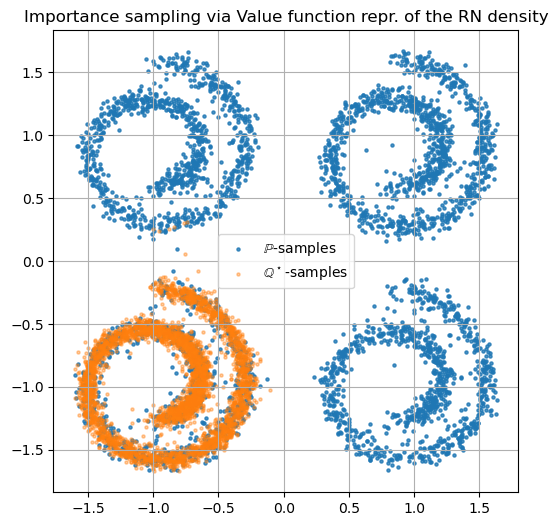

In [16]:
def importance_sampler(X_0, weights):
    dataset = TensorDataset(X_0)
    sampler = WeightedRandomSampler(weights, len(weights))
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                             sampler=sampler,
                                             batch_size = 1000,
                                             drop_last = False
                                             )
    return dataloader


Q_star_dataloader = importance_sampler(X_0=X_trajectories[-1].view(-1, X_trajectories.shape[-1]),
                                       weights=rn_density.view(-1)
                                       )

all_Q_star_data = []
for q_data in Q_star_dataloader:
    all_Q_star_data.append(q_data[0].cpu())

all_Q_star_data = torch.cat(all_Q_star_data, dim = 0).cpu()[:x_0.shape[0]]

fig, axs = plt.subplots(1, 1, figsize = (FIG_COLSIZE, FIG_ROWSIZE))

axs.scatter(x_0[:, 0].cpu(), x_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .8, label = r'$\mathbb{P}$-samples')
axs.scatter(all_Q_star_data[:, 0].cpu(), all_Q_star_data[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .4, label = r'$\mathbb{Q}^\star$-samples')
axs.grid(True)
axs.legend(loc = 'best')
plt.title('Importance sampling via Value function repr. of the RN density')
plt.show()


Find optimal control.

In [90]:
# def make_optimal_controller(sde, score_model, lambda_star, constraints, num_trajectories = 100):
#     rev_sde = sde.reverse(score_fn=score_model)
#     def optimal_controller(x_t, t):
#         xx = x_t.repeat(num_trajectories, 1).to(device)
#         tt = t.repeat(num_trajectories, 1).to(device)

#         xx_trajectories_list, _ = forward(sde=rev_sde,
#                                           x_0=xx,
#                                           t_0=tt,
#                                           controller=None,
#                                           is_backward=True
#                                           )

#         N, d = x_t.shape
#         xx_T = xx_trajectories_list[-1].to(x_t.device)

#         slacks = (-lambda_star.unsqueeze(0) * constraints(xx_T).view(num_trajectories, N, -1)).sum(-1) # [B, N]

#         mean, std = sde.marginal_prob(xx_T, tt)
#         mean = mean.view(-1, N, d) # [B, N, 2]
#         std = std.view(-1, N, 1) # [B, N, 1]

#         y = xx.view(-1, N, d)

#         plt.hist(xx_T[:, 0].cpu())
#         print(y[:, 0, 0])
#         plt.show()

#         forward_grad_log_p = -1 / std**2 * (y - mean) # [B, N, 2]

#         dV_slacks = (slacks.unsqueeze(-1).exp() * forward_grad_log_p).mean(0) / slacks.unsqueeze(-1).exp().mean(0) # [N, 2]
#         dV_score = score_model(x_t, t) 

#         # dV_slacks = -1. * torch.ones_like(dV_slacks)
#         dV = 0 * dV_score + dV_slacks

#         # dV = -dV_slacks
#         print('dV slacks: ', dV_slacks)
#         # print('score: ', dV_score, '\t control: ', dV)

#         return dV
    
#     return optimal_controller



class OptimalController():
    """ Optimal Controller that estimates the gradient of the value function by reparametrization trick. """
    def __init__(self, sde, score_model, value_func, lambda_star, constraints, n_perturbations = 100, sigma = 0.1):
        self.sde = sde
        self.score_model = score_model
        self.value_func = value_func
        self.lambda_star = lambda_star
        self.constraints = constraints
        self.n_perturbations = n_perturbations
        self.sigma = sigma
        
    def __call__(self, x_t, t):

        rev_sde = self.sde.reverse(score_fn=self.score_model)

        x_t_copies = x_t.repeat(self.n_perturbations, 1)
        t_copies = t.repeat(self.n_perturbations, 1)
        z = self.sigma * torch.randn_like(x_t_copies)

        weights = -z / self.sigma**2

        all_V = value_func(x_t=x_t_copies + z, t = t_copies, return_trajectories=False).unsqueeze(-1)
        # for i in tqdm.tqdm(range(n_perturbations)):
        #     V_i = value_func(x_t=x_t_copies[i] + z[i], t=t, return_trajectories=False)
        #     all_V.append(V_i)

        # all_V = torch.stack(all_V, dim = 0)

        Vgrad = (all_V * weights).view(self.n_perturbations, -1, x_t.shape[-1]).mean(0)
        # print('Vgrad: ', Vgrad)

        return Vgrad
    

class OptimalControllerv2():
    def __init__(self, sde, score_model, lambda_star, constraints):
        self.sde = sde
        self.score_model = score_model
        # self.value_func = value_func
        self.lambda_star = lambda_star
        self.constraints = constraints
        # self.n_perturbations = n_perturbations
        # self.sigma = sigma
        
    def __call__(self, x_t, t):

        # rev_sde = self.sde.reverse(score_fn=self.score_model)

        # x_t_copies = x_t.repeat(self.n_perturbations, 1)
        # t_copies = t.repeat(self.n_perturbations, 1)
        # z = self.sigma * torch.randn_like(x_t_copies)

        # weights = -z / self.sigma**2

        # all_V = value_func(x_t=x_t_copies + z, t = t_copies, return_trajectories=False).unsqueeze(-1)
        # # for i in tqdm.tqdm(range(n_perturbations)):
        # #     V_i = value_func(x_t=x_t_copies[i] + z[i], t=t, return_trajectories=False)
        # #     all_V.append(V_i)

        # # all_V = torch.stack(all_V, dim = 0)

        # Vgrad = (all_V * weights).view(self.n_perturbations, -1, x_t.shape[-1]).mean(0)
        # # print('Vgrad: ', Vgrad)


        num_trajectories = 1000
        xx = x_t.repeat(num_trajectories, 1).to(device)
        tt = t.repeat(num_trajectories, 1).to(device)

        betas = sde.beta_0 + tt * (sde.beta_1 - sde.beta_0) 
        sigmas = torch.sqrt(betas)
        ind = torch.randint(low=0, high=X.shape[0]-1, size=(xx.shape[0],))
        y_0 = X[ind]


        mean, std = sde.marginal_prob(x=y_0, t=tt)

        forward_grad_log_p = -1 / std**2 * (xx - mean) # [B, N, 2]
        forward_grad_log_p = forward_grad_log_p.view(num_trajectories, *x_t.shape)

        slacks = (-self.lambda_star.unsqueeze(0) * self.constraints(y_0).view(num_trajectories, x_t.shape[0], -1)).sum(-1) # [B, N]
        # slacks = torch.zeros_like(slacks)

        dV_slacks = (slacks.unsqueeze(-1).exp() * forward_grad_log_p).mean(0)
        # dV_slacks = slacks / slacks.unsqueeze(-1).exp().mean(0) # [N, 2]
        
        
        dV_score = score_model(x_t, t) 

        # dV_slacks = -1. * torch.ones_like(dV_slacks)
        dV = 0 * dV_score + 1 * dV_slacks

        # dV = -dV_slacks
        # print('dV slacks: ', dV_slacks)
        # print('score: ', dV_score, '\t control: ', dV)

        return dV
    



class OptimalControllerv3():
    def __init__(self, sde, score_model, lambda_star, constraints):
        self.sde = sde
        self.score_model = score_model
        # self.value_func = value_func
        self.lambda_star = lambda_star
        self.constraints = constraints
        # self.n_perturbations = n_perturbations
        # self.sigma = sigma
        
    def __call__(self, x_t, t):

        # rev_sde = self.sde.reverse(score_fn=self.score_model)

        # x_t_copies = x_t.repeat(self.n_perturbations, 1)
        # t_copies = t.repeat(self.n_perturbations, 1)
        # z = self.sigma * torch.randn_like(x_t_copies)

        # weights = -z / self.sigma**2

        # all_V = value_func(x_t=x_t_copies + z, t = t_copies, return_trajectories=False).unsqueeze(-1)
        # # for i in tqdm.tqdm(range(n_perturbations)):
        # #     V_i = value_func(x_t=x_t_copies[i] + z[i], t=t, return_trajectories=False)
        # #     all_V.append(V_i)

        # # all_V = torch.stack(all_V, dim = 0)

        # Vgrad = (all_V * weights).view(self.n_perturbations, -1, x_t.shape[-1]).mean(0)
        # # print('Vgrad: ', Vgrad)

        
        num_trajectories = 10000
        xx = x_t.repeat(num_trajectories, 1).to(device)


        tt = t.repeat(num_trajectories, 1).to(device)

        betas = sde.beta_0 + tt * (sde.beta_1 - sde.beta_0) 
        sigmas = torch.sqrt(betas)
        ind = torch.randint(low=0, high=X.shape[0]-1, size=(xx.shape[0],))
        y_0 = X[ind]

        mean, std = sde.marginal_prob(x=y_0, t=tt)

        log_p = -torch.linalg.vector_norm(xx - mean, dim = -1, keepdim = True) / (2 * sigmas**2) - torch.log(2*np.pi + sigmas**2) / 2


        slacks = (-self.lambda_star.unsqueeze(0) * self.constraints(y_0).view(num_trajectories, x_t.shape[0], -1)).sum(-1)
        # print('slacks.mean(): ', slacks.mean())
        # slacks = slacks / slacks.exp().mean()
        
        V_slacks = (slacks + log_p.view_as(slacks)).exp() #[B, N]

        dV_slacks = V_slacks.unsqueeze(-1) * ((xx - mean) / (sigmas**2)).view(num_trajectories, *x_t.shape)
 
        dV_slacks = dV_slacks.mean(0) / V_slacks.mean(0).unsqueeze(-1)

        # slacks = (-self.lambda_star.unsqueeze(0) * self.constraints(y_0).view(num_trajectories, x_t.shape[0], -1)).sum(-1) # [B, N]
        # # slacks = torch.zeros_like(slacks)

        # dV_slacks = (slacks.unsqueeze(-1).exp() * forward_grad_log_p).mean(0)
        # # dV_slacks = slacks / slacks.unsqueeze(-1).exp().mean(0) # [N, 2]
        
        
        dV_score = score_model(x_t, t) 

        # dV_slacks = -1. * torch.ones_like(dV_slacks)
        dV = -1 * dV_score + 1 * dV_slacks

        # dV = -dV_slacks
        # print('dV slacks: ', dV_slacks)
        # print('score: ', dV_score, '\t control: ', dV)

        return dV
    

class MLPController():
    """ MLP Controller that optimizes the Lagrangian directly to learn the optimal control. """
    def __init__(self, sde, score_model, value_func, lambda_star, constraints, controller_model = None, train_controller = True, num_trajectories = 100):
        self.sde = sde
        self.score_model = score_model
        self.value_func = value_func
        self.lambda_star = lambda_star
        self.constraints = constraints
        self.num_trajectories = num_trajectories
        
        if controller_model is None:
            if MODEL == 'FCNN':
                nblocks = 6 if MULTI_SWISSROLL else 4
                nunits = 64
                controller_model = DiffusionModel(nfeatures=2, nblocks=nblocks, nunits = nunits)

            elif MODEL == 'ConditionalLinear':
                nblocks = 6 if MULTI_SWISSROLL else 4
                nunits = 128
                controller_model = ConditionalLinearModel(nsteps=diffusion_steps, nfeatures=2, nblocks=nblocks, nunits=nunits)
            else:
                raise NotImplementedError
         
        self.controller_model = controller_model
        if train_controller:
            self.controller_model = self.train(model=self.controller_model,
                                               num_trajectories=self.num_trajectories
                                               )


    def train(self, model, num_trajectories):
        import torch.optim as optim

        if MULTI_SWISSROLL:
            nepochs = 500
            batch_size = 10000
            lr = 1e-3
            end_factor = 0.1

            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=end_factor, total_iters=nepochs)

        else:
            nepochs = 100
            batch_size = 2048
            lr = 1e-3
            end_factor = 0.01

            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

        
        X_0 = self.sde.prior_sampling((10000, 2))

        for epoch in range(nepochs):

            epoch_loss = steps = 0
            # for Xbatch in X_dataloader:
            for i in range(0, len(X_0), batch_size):
                def controlled_score_fn(x_t, t):
                    return 1 * score_model(x_t, t) + model(x_t, t)
                rev_sde = sde.reverse(score_fn=controlled_score_fn)
                Xbatch = X[i:i+batch_size]


                timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
                noised, eps = noise(Xbatch, timesteps)
                predicted_noise = model(noised.to(device), timesteps.to(device))
                loss = loss_fn(predicted_noise, eps.to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss
                steps += 1

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch} loss = {epoch_loss / steps}")


        return model
        
    def __call__(self, x_t, t):

        u_theta = self.control_model(x_t, t)

        return u_theta





def make_optimal_controller(sde, score_model, value_func, lambda_star, constraints, num_trajectories = 100):
    rev_sde = sde.reverse(score_fn=score_model)


    def optimal_controller(x_t, t):

        n_perturbations = num_trajectories
        sigma = 0.1
        x_t_copies = x_t.repeat(n_perturbations, 1)
        t_copies = t.repeat(n_perturbations, 1)
        z = sigma * torch.randn_like(x_t_copies)

        weights = -z / sigma**2

        all_V = value_func(x_t=x_t_copies + z, t = t_copies, return_trajectories=False).unsqueeze(-1)
        # for i in tqdm.tqdm(range(n_perturbations)):
        #     V_i = value_func(x_t=x_t_copies[i] + z[i], t=t, return_trajectories=False)
        #     all_V.append(V_i)

        # all_V = torch.stack(all_V, dim = 0)

        Vgrad = (all_V * weights).view(n_perturbations, -1, x_t.shape[-1]).mean(0)
        # print('Vgrad: ', Vgrad)

        return Vgrad

        # xx = x_t.repeat(num_trajectories, 1).to(device)
        # tt = t.repeat(num_trajectories, 1).to(device)

        # xx_trajectories_list, _ = forward(sde=rev_sde,
        #                                   x_0=xx,
        #                                   t_0=tt,
        #                                   controller=None,
        #                                   is_backward=True
        #                                   )

        # N, d = x_t.shape
        # xx_T = xx_trajectories_list[-1].to(x_t.device)

        # slacks = (-lambda_star.unsqueeze(0) * constraints(xx_T).view(num_trajectories, N, -1)).sum(-1) # [B, N]

        # mean, std = sde.marginal_prob(xx_T, tt)
        # mean = mean.view(-1, N, d) # [B, N, 2]
        # std = std.view(-1, N, 1) # [B, N, 1]

        # y = xx.view(-1, N, d)

        # plt.hist(xx_T[:, 0].cpu())
        # print(y[:, 0, 0])
        # plt.show()

        # forward_grad_log_p = -1 / std**2 * (y - mean) # [B, N, 2]

        # dV_slacks = (slacks.unsqueeze(-1).exp() * forward_grad_log_p).mean(0) / slacks.unsqueeze(-1).exp().mean(0) # [N, 2]
        # dV_score = score_model(x_t, t) 

        # # dV_slacks = -1. * torch.ones_like(dV_slacks)
        # dV = 0 * dV_score + dV_slacks

        # # dV = -dV_slacks
        # print('dV slacks: ', dV_slacks)
        # # print('score: ', dV_score, '\t control: ', dV)

        # return dV
    
    return optimal_controller

Run controlled diffusion SDE.

In [91]:

# t = torch.ones_like(t) 
# X_0 = sde.prior_sampling(X.shape)
# controller = score_model
# diffusion_sde = sde.reverse(score_fn=controller)

N = 80
num_trajectories = 10
n_perturb = 10
sigma = 0.5

x_0 = sde.prior_sampling((N, 2))
# x_0 = torch.ones_like(x_0)
t = torch.ones_like(x_0)[:, 0:1]

# optimal_controller = make_optimal_controller(sde=sde,
#                                              score_model=score_model,
#                                              value_func=make_value_func(rev_sde=diffusion_sde,
#                                                                         constraints=constraints,
#                                                                         lambda_star=lambdas_t[-1],
#                                                                         num_trajectories=num_trajectories),
#                                              lambda_star=lambdas_t[-1],
#                                              constraints=constraints,
#                                              num_trajectories=B
#                                              )




optimal_controller = OptimalController(sde=sde,
                                       score_model=score_model,
                                       value_func=make_value_func(rev_sde=diffusion_sde,
                                                                  constraints=constraints,
                                                                  lambda_star=lambdas_t[-1],
                                                                  num_trajectories=num_trajectories),
                                       lambda_star=lambdas_t[-1],
                                       constraints=constraints,
                                       n_perturbations=n_perturb,
                                       sigma=sigma  
                                       )

# optimal_controller = OptimalControllerv3(sde=sde,
#                                          score_model=score_model,
#                                          lambda_star=lambdas_t[-1],
#                                          constraints=constraints
#                                          )

optimal_controller = OptimalControllerv4()

def controlled_score_fn(x_t, t):
    return 1 * score_model(x_t, t) + optimal_controller(x_t, t)

controlled_diffusion_sde = sde.reverse(score_fn=controlled_score_fn)

# u_star = optimal_controller(x_t=x_0, t=t)


# t = torch.full([X.shape[0], 1], 50/(sde.N-1)).to(device)
# t = torch.randint(low = 0, high=sde.N-1, size = t.size(), device = t.device) / sde.N-1

Xgen_controlled_hist, Tgen_controlled_hist = forward(sde=controlled_diffusion_sde, x_0=x_0, t_0=t, controller=controlled_score_fn, gamma=1, is_backward=True, verbose=True)
# controller = make_controller(sde=sde, lambda_star=lambda_star)
# Xgen_controlled_hist, Tgen_controlled_hist = forward(sde=sde, x_0=X, t_0=t, controller=controller, gamma=1)  

Reverse process timestep:  tensor([199], device='cuda:0')


slacks.mean():  tensor(-11.2319, device='cuda:0')
slacks.mean():  tensor(-11.2452, device='cuda:0')
Reverse process timestep:  tensor([198], device='cuda:0')
slacks.mean():  tensor(-11.2432, device='cuda:0')
slacks.mean():  tensor(-11.2206, device='cuda:0')
Reverse process timestep:  tensor([196], device='cuda:0')
slacks.mean():  tensor(-11.2363, device='cuda:0')
slacks.mean():  tensor(-11.2516, device='cuda:0')
Reverse process timestep:  tensor([195], device='cuda:0')
slacks.mean():  tensor(-11.2363, device='cuda:0')
slacks.mean():  tensor(-11.2326, device='cuda:0')
Reverse process timestep:  tensor([194], device='cuda:0')
slacks.mean():  tensor(-11.2350, device='cuda:0')
slacks.mean():  tensor(-11.2388, device='cuda:0')
Reverse process timestep:  tensor([193], device='cuda:0')
slacks.mean():  tensor(-11.2380, device='cuda:0')
slacks.mean():  tensor(-11.2455, device='cuda:0')
Reverse process timestep:  tensor([192], device='cuda:0')
slacks.mean():  tensor(-11.2290, device='cuda:0')
sl

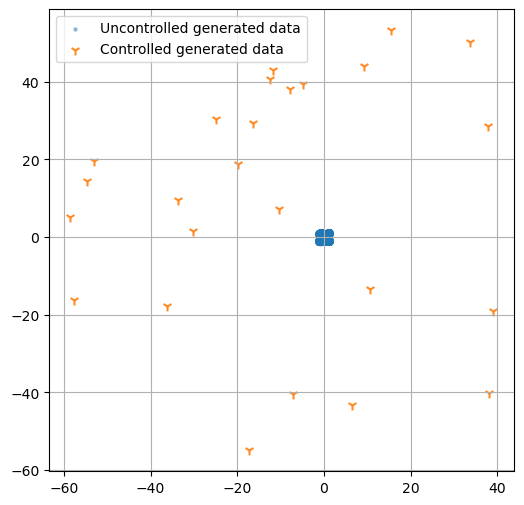

Percentage of feasible points:  tensor(0.0500)
tensor(0.6875)


In [83]:
fig, axs = plt.subplots(1, 1, figsize = (1 * FIG_COLSIZE, 1 * FIG_ROWSIZE))

idx = -2

axs.scatter(Xgen_hist[idx][:, 0].cpu(), Xgen_hist[idx][:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.4, label = 'Uncontrolled generated data')
axs.scatter(Xgen_controlled_hist[idx][:, 0].cpu(), Xgen_controlled_hist[idx][:, 1].cpu(), s = 10 * SCATTER_POINT_SIZE, marker="1", alpha=0.9, label = 'Controlled generated data')

# axs[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
# axs.scatter(Xgen_controlled_hist[-1][:, 0].cpu(), Xgen_controlled_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Controlled generated data')

axs.grid(True)
axs.legend(loc = 'best')

plt.show()

print('Percentage of feasible points: ',  (1. * (Xgen_controlled_hist[idx].max(dim = -1)[0] < 0)).mean())
print( (1. * torch.isnan(Xgen_controlled_hist[idx])).mean() )

In [ ]:
def plot_gradients_v2(model, data, plot_scatter=True, plot_timestep = 1, is_noise_model = False, axs = None):
    # device = 'cpu'
    timestep = plot_timestep
    xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
    scores = []
    for i in range(xx.shape[0]):
        x = xx[i:i+1]
        score = model(torch.tensor(x).float().to(device), timestep/(DIFFUSION_STEPS-1) * torch.ones(size = (x.shape[0], 1)).to(device)).detach().cpu()
        scores.append(score)
    
    scores = torch.cat(scores, dim = 0)
    # scores = model(torch.tensor(xx).float().to(device), timestep/(DIFFUSION_STEPS-1) * torch.ones(size = (xx.shape[0], 1)).to(device)).detach().cpu()
    if is_noise_model:
        scores = (-1/(1 - baralphas[timestep])**0.5 * scores).detach().cpu()
    
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    if axs is None:
        # Perform the plots
        plt.figure(figsize=(16,12))
        if (plot_scatter):
            plt.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
        plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.title(f'Timestep {timestep} \t model_sigma = {model.sigma}, \n model_n_perturb = {model.n_perturbations}')
        # plt.tight_layout()
    else:
        if (plot_scatter):
            axs.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
        axs.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
        axs.set_xlim(-3, 3)
        axs.set_ylim(-3, 3)
        axs.set_title(f'Timestep {timestep}, model_sigma = {model.sigma},\n model_n_perturb = {model.n_perturbations}')
        # plt.tight_layout()
        plt.show()

hdr_plot_style()
# fig, axs = plt.subplots(1, 1, figsize = (FIG_COLSIZE, FIG_ROWSIZE))
# score_model = make_score_model(sde=sde, noise_model=model, accel_factor=1, DEBUG = False)

controllers = []
for num_trajectories in [10, 100, 1000]:
    for n_perturb in [10, 100, 1000]:
        for sigma in [0.5, 0.1, 0.02]:
            fig, axs = plt.subplots(1, 1, figsize = (FIG_COLSIZE, FIG_ROWSIZE))
            controller = OptimalController(sde=sde,
                                           score_model=score_model,
                                           value_func=make_value_func(rev_sde=diffusion_sde,
                                                                      constraints=constraints,
                                                                      lambda_star=lambdas_t[-1],
                                                                      num_trajectories=num_trajectories),
                                           lambda_star=lambdas_t[-1],
                                           constraints=constraints,
                                           n_perturbations=n_perturb,
                                           sigma=sigma
                                           )
            print(f'Sigma = {sigma}, n_perturb = {n_perturb}, n_trajectories = {num_trajectories}')
            plot_gradients_v2(controller, X.cpu(), plot_timestep=1, is_noise_model=False, axs=axs)
            plt.close(fig)

    

# for t in range(1, DIFFUSION_STEPS, 99):
# plot_gradients_v2(optimal_controller, X.cpu(), plot_timestep=1, is_noise_model=False, axs=axs)


matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [ ]:
def u_true(sde, x, t, lambda_star, constraint_tol = 0., include_sigma = False):
    timesteps = sde.timestep(t)

    baralphas_T_minus_t = sde.sqrt_alphas_cumprod[-1] / sde.sqrt_alphas_cumprod[timesteps]
    mean = (baralphas_T_minus_t * x - constraint_tol)
    std = torch.sqrt(1 - baralphas_T_minus_t**2)
    # mean, std = sde.marginal_prob(x=x, t=t)
    # beta_t = sde.beta_0 + t * (sde.beta_1 - sde.beta_0)
    beta_t = sde.discrete_betas[timesteps]
    sigma_t = torch.sqrt(beta_t)
    dV = mean / x
    
    if not include_sigma:
        return -dV * lambda_star.unsqueeze(0)
    else:
        return -sigma_t * dV * lambda_star.unsqueeze(0)
    


def value_true(sde, x, t, lambda_star, constraint_tol = 0.):
    baralphas_T_minus_t = sde.sqrt_alphas_cumprod[-1] / sde.sqrt_alphas_cumprod[timesteps]
    mean = (baralphas_T_minus_t * x - constraint_tol)
    std = torch.sqrt(1 - baralphas_T_minus_t**2)
    V = (lambda_star.unsqueeze(0) * mean).sum(-1) - 0.5 * std.squeeze(-1)**2 * torch.linalg.vector_norm(lambda_star).pow(2)

    return V.unsqueeze(-1)

CONSTRAINT_TOL = -0.5

timesteps = torch.arange(sde.N).to(device).view(-1, 1)
t = (timesteps) / (sde.N - 1)

sample_id = torch.randint(low = 0, high = X.shape[0]-1, size = (1,))
print('sample_id: ', sample_id)
x = X[sample_id:sample_id+1].to(device)

mean, std = sde.marginal_prob(x=x, t=t)

mean_discrete = sde.sqrt_alphas_cumprod[timesteps] * x
std_discrete = sde.sqrt_1m_alphas_cumprod[timesteps]

lambda_star = torch.tensor([-CONSTRAINT_TOL * 1] * 2).to(device).view(-1)

u = u_true(sde=sde, x=x, t=t, lambda_star=lambda_star, constraint_tol=CONSTRAINT_TOL, include_sigma=True)
# print('u: ', u)

V = value_true(sde=sde, x=x, t=t, lambda_star=lambda_star, constraint_tol=CONSTRAINT_TOL)
# print('V: ', V)

# dx = 1e-10
# V_dx_shifted = value_true(sde=sde, x=x + torch.tensor([dx/2, 0]).to(device), t=t, lambda_star=lambda_star)
# V_minus_dx_shifted = value_true(sde=sde, x=x + torch.tensor([-dx/2, 0]).to(device), t=t, lambda_star=lambda_star)
# # print('V_dx_shifted: ', V_dx_shifted)

# print('[ V(x + dx, t) - V(x, t) ] / dx:\n',  (V_dx_shifted - V_minus_dx_shifted) / dx)
# print('-u_star / sigma_t: ', -u[:, 0] / torch.sqrt(sde.discrete_betas[timesteps]) )

fig, axs = plt.subplots(1, 4, figsize = (4 * FIG_COLSIZE, 1 * FIG_ROWSIZE))
axs[0].plot(timesteps.cpu(), mean_discrete.cpu(), marker = 'd', markevery = len(timesteps) // 20, label = [f"Discrete mean $\mu_{{{i}}}$" for i in [1, 2]])
axs[0].set_ylabel(r'$\mathbb{E}[\mathbf{x}_t \,|\, \mathbf{x}_0]$')
axs[0].plot(timesteps.cpu(), mean.cpu(), label = [f"Cts mean $\mu_{{{i}}}$" for i in [1, 2]])


axs[1].plot(timesteps.cpu(), std_discrete.cpu(), marker = 'd', markevery = len(timesteps) // 20, label = f"Discrete std $\sigma$")
axs[1].plot(timesteps.cpu(), std.cpu(), label = f"Cts std $\sigma$")
axs[1].set_ylabel(r'$\sqrt{Var [\mathbf{x}_t \,|\, \mathbf{x}_0]}$')

axs[2].plot(timesteps.cpu(), u.cpu(), label = [f"$u_{{{i}}}^\star(x, t)$" for i in [1, 2]])
axs[2].set_ylabel(r'Optimal control $\mathbf{u}^\star$')
axs[3].plot(timesteps.cpu(), V.cpu(), label = r'$V(\mathbf{x}, t)$')
axs[3].set_ylabel('Value function')
# axs[3].plot(timesteps.cpu(), V_dx_shifted.cpu(), label = r'$V(x + dx, t)$')

for ax in axs:
    ax.set_xlabel('Timestep (t)')
    ax.grid(True)
    ax.legend(loc = 'best')
plt.show()


## Create a reverse sampler.

In [ ]:
def make_controller(sde, lambda_star):

    def controller(x, t):
        u_star = u_true(sde=sde, x=x, t=t, lambda_star=lambda_star)
        return u_star
    
    return controller


def forward(sde, x_0, t_0 = None, t_1 = None, controller = None, gamma = 1., no_sde_drift = False):
    """ Simulate discretized SDE with optional control input from cts time \tau = t_0 until \tau = t_1. """
    dt = 1 / (sde.N - 1)
    t_0 = torch.zeros_like(x_0)[:, 0:1] if t_0 is None else t_0
    t_1 = torch.ones_like(x_0)[:, 0:1] if t_1 is None else t_1

    with torch.no_grad():
        xt = [x_0]
        tt = [t_0]
        zt = [[None]]
        ut = [[None]]

        x = x_0.clone()
        t = t_0.clone()
        
        while torch.any(t < t_1):
            f, G = sde.discretize(x, t) # G = \sigma_t * sqrt(dt)

            # beta_t = sde.beta_0 + t * (sde.beta_1 - sde.beta_0) # linear SDE
            # sigma_t = torch.sqrt(beta_t)

            f = 0 if no_sde_drift else f

            # timestep = (t / (sde.N - 1)).to(torch.long)
            # betas = sde.discrete_betas[timestep]
            # sigma_t = torch.sqrt(betas)

            with torch.set_grad_enabled(True):
                if controller is not None:
                    u = controller(x, t)
                    u[torch.isnan(u)] = 0.
                    # f = f + gamma * (G / dt**0.5) * u * dt
                    f = f + gamma * G**2  * u
                else:
                    u = None

            z = torch.randn_like(x)
            x = x + (t < t_1) * (f + G * z)
            t = t + (t < t_1) * dt

            xt += [x.detach().cpu()]
            tt += [t.detach().cpu()]
            zt += [z.detach().cpu()]
            if controller is not None:
                ut += [u.detach().cpu()]

        if controller is not None:
            return xt, (tt, ut, zt)
        else:
            return xt, (tt, zt)
    
timesteps = torch.randint(low = 0, high = sde.N - 1, size = (X.shape[0], 1), device = device)
t = timesteps / (sde.N - 1)
t = torch.zeros_like(t)

# t = torch.full([X.shape[0], 1], 50/(sde.N-1)).to(device)
# t = torch.randint(low = 0, high=sde.N-1, size = t.size(), device = t.device) / sde.N-1

Xgen_hist, Tgen_hist = forward(sde=sde, x_0=X, t_0=t, controller=None, gamma=1)
controller = make_controller(sde=sde, lambda_star=lambda_star)
Xgen_controlled_hist, Tgen_controlled_hist = forward(sde=sde, x_0=X, t_0=t, controller=controller, gamma=1)    

In [ ]:

# fig, axs = plt.subplots(1, 2, figsize = (2 * FIG_COLSIZE, 1 * FIG_ROWSIZE))

# axs[0].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
# axs[0].scatter(Xgen_hist[-1][:, 0].cpu(), Xgen_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Uncontrolled generated data')

# axs[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
# axs[1].scatter(Xgen_controlled_hist[-1][:, 0].cpu(), Xgen_controlled_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Controlled generated data')

# for ax in axs:
#     ax.grid(True)
#     ax.legend(loc = 'best')
# plt.show()

fig, axs = plt.subplots(1, 1, figsize = (1 * FIG_COLSIZE, 1 * FIG_ROWSIZE))

# axs[0].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
axs.scatter(Xgen_hist[-1][:, 0].cpu(), Xgen_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Uncontrolled generated data')

# axs[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
axs.scatter(Xgen_controlled_hist[-1][:, 0].cpu(), Xgen_controlled_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Controlled generated data')

axs.grid(True)
axs.legend(loc = 'best')

plt.show()

In [ ]:
print(Xgen_hist[-1].mean(0))
print(Xgen_controlled_hist[-1].mean(0))

### Make linear terminal constraints.

In [ ]:
def my_indicator_fnc(value, thresh):
    '''
    Implements the differentiable indicator function I(value > thresh).
    '''
    soft_indicator = torch.sigmoid(value - thresh)
    indicator = (value > thresh).float() - soft_indicator.detach() + soft_indicator
    return indicator, soft_indicator 


def make_constraint_fnc(eval_type, rhs, dom_boundary_low = None, dom_boundary_high = None, rhs_leq_or_eq_to = True):

    dom_boundary_low = [-float("Inf"), -float("Inf")] if dom_boundary_low is None else dom_boundary_low
    dom_boundary_high = [float("Inf"), float("Inf")] if dom_boundary_high is None else dom_boundary_high

    if eval_type == 'linear':
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            mean = Xbatch - c
            return mean if rhs_leq_or_eq_to else -mean
        
    elif eval_type == 'quadratic':
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            variance = (Xbatch - Xbatch.mean(dim = 0, keepdim = True))**2 - c
            return variance if rhs_leq_or_eq_to else -variance
        

    elif eval_type == 'abs-linear':
        def constraint_fnc(Xbatch):
            tau = .5
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            mean = (torch.abs(Xbatch) - tau).abs() - c
            return mean if rhs_leq_or_eq_to else -mean

        
    elif eval_type == 'pinned-measure':
        # X > c entries across individual dimensions
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)

            # dom_boundary = torch.tensor([.5, -1]).repeat(Xbatch.shape[0], 1)
            dom_boundary_low = torch.tensor(dom_boundary_low).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            dom_boundary_high = torch.tensor(dom_boundary_high).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            # dom_boundary = torch.tensor([.5, .5]).repeat(Xbatch.shape[0], 1)
            
            ind_low, soft_ind_low = my_indicator_fnc(value=-Xbatch, thresh=-dom_boundary_low)
            ind_high, soft_ind_high = my_indicator_fnc(value=Xbatch, thresh=dom_boundary_high)
            ind = torch.stack([ind_low, ind_high], dim = -1)
            soft_ind = torch.stack([soft_ind_low, soft_ind_high], dim = -1)

            ind = torch.any(ind.bool(), dim = -1, keepdim=False) * 1.
            soft_ind = 1 - torch.prod((1 - soft_ind), dim = -1, keepdim=False)
            
            return ind - c if rhs_leq_or_eq_to else c - ind
        
    elif eval_type == 'pinned-measure-single-lambda':
        # X > c entries across all dimensions
        print('dom_boundary_low: ', dom_boundary_low)
        print('dom_boundary_high: ', dom_boundary_high)
        def constraint_fnc(Xbatch):
            c = torch.tensor(rhs).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            # dom_boundary = torch.tensor([.5, -1]).repeat(Xbatch.shape[0], 1)
            db_low = torch.tensor(dom_boundary_low).repeat(Xbatch.shape[0], 1).to(Xbatch.device)
            db_high = torch.tensor(dom_boundary_high).repeat(Xbatch.shape[0], 1).to(Xbatch.device)

            # dom_boundary = torch.tensor([.5, .5]).repeat(Xbatch.shape[0], 1)

            ind_low, soft_ind_low = my_indicator_fnc(value=-Xbatch, thresh=-db_low)
            ind_high, soft_ind_high = my_indicator_fnc(value=Xbatch, thresh=db_high)

            ind = torch.cat([ind_low, ind_high], dim = -1)
            soft_ind = torch.cat([soft_ind_low, soft_ind_high], dim = -1)

            ind = torch.any(ind.bool(), dim = -1, keepdim=True) * 1.
            soft_ind = 1 - torch.prod((1 - soft_ind), dim = -1, keepdim=True)

            return ind - c if rhs_leq_or_eq_to else c - ind
        
    else:
        raise NotImplementedError

    return constraint_fnc

Linear constraints:

In [ ]:
CONSTRAINT_TYPE = 'linear'
CONSTRAINT_RHS = [CONSTRAINT_TOL] * 2

constraints = make_constraint_fnc(eval_type=CONSTRAINT_TYPE, rhs=CONSTRAINT_RHS, rhs_leq_or_eq_to=True)

print('Unconstrained OU process constraint slacks: ', constraints(Xbatch=Xgen_hist[-1]).mean(0))
print('Constrained OU process constraint slacks: ', constraints(Xbatch=Xgen_controlled_hist[-1]).mean(0))

### Compute the optimal dual multipliers.

In [ ]:
# CONSTRAINT_TYPE = 'linear'
# CONSTRAINT_RHS = [-2, -2]

# constraints = make_constraint_fnc(eval_type=CONSTRAINT_TYPE, rhs=CONSTRAINT_RHS)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def get_train_optimal_lambdas_settings(eval_type):
    '''
    Retrieve training hyperparameters for finding optimal dual multipliers. 
    '''

    settings = {}
    if eval_type in ['linear']:
        settings['lr'] = 2e-1
        settings['niters'] = 200

    elif eval_type in ['abs-linear']:
        settings['lr'] = 5.
        settings['niters'] = 500

    elif eval_type == 'quadratic':
        settings['lr'] = 5e-1
        settings['niters'] = 200

    elif eval_type in ['pinned-measure', 'pinned-measure-single-lambda']:
        settings['lr'] = 5. # 1
        settings['niters'] = 200 # 500

    else:
        raise NotImplementedError

    return settings


def train_optimal_lambdas(lambdas_init, constraints, x_0, niters = 100, lr=1e-1, DEBUG = False):
    '''
    Training loop to find the optimal dual multipliers and the associated change of measure. 
    '''

    lambdas = lambdas_init.clone().requires_grad_(True)
    all_lambdas = []
    all_dQ_star_div_dP = []
    all_Q_star_constraints = []

    with torch.no_grad():
        dQ_star_div_dP = optimal_change_of_measure(lambdas_star=lambdas, constraints=constraints, x_0=x_0)
        Q_star_constraints = (constraints(x_0) * dQ_star_div_dP.unsqueeze(-1)).mean(dim = 0)

        all_lambdas.append(lambdas.detach().clone())
        all_dQ_star_div_dP.append(dQ_star_div_dP.detach().clone())
        all_Q_star_constraints.append(Q_star_constraints.detach().clone())

    with torch.set_grad_enabled(True):
        for iter in range(niters):
            loss = (-lambdas * constraints(x_0)).sum(-1).exp().mean(dim = 0)
            loss.backward()

            with torch.no_grad():
                lambdas -= lr * lambdas.grad
                lambdas.data.clamp_(0)
            lambdas.grad.zero_()

            if (iter + 1) % 5 == 0 and DEBUG:
                print(f'iter: {iter} \t loss: {loss.item()} \t lambdas: {lambdas}')

            with torch.no_grad():
                dQ_star_div_dP = optimal_change_of_measure(lambdas_star=lambdas, constraints=constraints, x_0=x_0)
                Q_star_constraints = (constraints(x_0) * dQ_star_div_dP.unsqueeze(-1)).mean(dim = 0)

                all_lambdas.append(lambdas.detach().clone())
                all_dQ_star_div_dP.append(dQ_star_div_dP.detach().clone())
                all_Q_star_constraints.append(Q_star_constraints.detach().clone())

    return all_lambdas, all_dQ_star_div_dP, all_Q_star_constraints


def optimal_change_of_measure(lambdas_star, constraints, x_0):
    return (-lambdas_star * constraints(x_0)).sum(-1).exp() / (-lambdas_star * constraints(x_0)).sum(-1).exp().mean(dim = 0, keepdim=True)


# Initialize lambdas
lambdas = torch.tensor([0.0] * constraints(X).shape[-1]).to(X.device)

# Get training settings.
settings = get_train_optimal_lambdas_settings(eval_type=CONSTRAINT_TYPE)

# Retrieve terminal data distribution for reference (unconstrained) generative process
x_0 = Xgen_hist[-1].to(device)

lambdas_t, dQ_star_div_dP_t, constraints_Q_t = train_optimal_lambdas(lambdas_init=lambdas,
                                                                     constraints=constraints,
                                                                     x_0=x_0,
                                                                     niters=settings['niters'],
                                                                     lr=settings['lr'],
                                                                     DEBUG = True
                                                                     )

Visualize optimal change of measure (RN-density) through the optimal dual multipliers.

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler

P_constraints = constraints(x_0).mean(dim = 0)
Q_star_constraints = (constraints(x_0) * dQ_star_div_dP_t[-1].unsqueeze(-1)).mean(dim = 0)
KL_DIV = [(dQ_star_div_dP_t[k] * dQ_star_div_dP_t[k].log()).mean().item() for k in range(len(dQ_star_div_dP_t))]
# values = []
# for idx in tqdm.tqdm(range(X_1.shape[0])):
#     value = value_func(x_t=X_1[idx], t=torch.tensor(1), sde=sde, constraints=constraints, lambdas=lambdas, num_trajectories=100)
#     values.append(value.item())

# V_0 = np.mean(values).item()
# print('Expected value function V_0: ', V_0)

if CONSTRAINT_TYPE in ['pinned-measure', 'pinned-measure-single-lambda']:
    q = torch.tensor(CONSTRAINT_RHS).to(device)
    p_D0 = 1 - (q + P_constraints)
    lambdas_star_hat = ((1/p_D0 - 1) * (1/q - 1)).log().data.clamp_(0)

    print('Lambdas_star_hat: ', lambdas_star_hat)


x_0_Q_star_dataset = TensorDataset(x_0)
Q_star_sampler = WeightedRandomSampler(dQ_star_div_dP_t[-1], len(dQ_star_div_dP_t[-1]))
Q_dataloader = torch.utils.data.DataLoader(dataset=x_0_Q_star_dataset,
                                            sampler=Q_star_sampler,
                                            batch_size = 1000,
                                            drop_last = False
                                            )

# print('Dataset length: ', len(x_0_Q_star_dataset))
# print('Dataloader length: ', len(Q_dataloader))

all_Q_data = []
for q_data in Q_dataloader:
    # print(q_data[0].shape) # [sampler.num_samples, 2]
    # print('Batch size: ', q_data[0].shape)
    all_Q_data.append(q_data[0])

all_Q_data = torch.cat(all_Q_data, dim = 0)
# print(all_Q_data.shape)
# plt.scatter(x_0[:, 0], x_0[:, 1], label = r'$\mathbb{P}$-samples')
# plt.scatter(all_Q_data[:, 0], all_Q_data[:, 1], label = r'$\mathbb{Q}^\star$-samples')
# plt.legend(loc = 'best')
# plt.show()

fig, axs = plt.subplots(2, 3, figsize = (3 * FIG_COLSIZE, 2 * FIG_ROWSIZE))

axs[0, 0].plot(np.arange(len(lambdas_t)), torch.stack(lambdas_t, dim = 0).cpu(), label = ['\lambda^\star_{}'.format(_) for _ in range(lambda_star.shape[-1])])
axs[0, 0].set_xlabel('Iteration (k)')
axs[0, 0].set_ylabel('Dual multipliers')
axs[0, 0].grid(True)
# axs[0].legend(loc = 'best') if len(CONSTRAINT_RHS) > 1 else None

if CONSTRAINT_TYPE in ['pinned-measure', 'pinned-measure-single-lambda']:
    if torch.any(torch.isnan(lambdas_star_hat)):
        print('Nan lambda star')
    else:
        for j in range(lambdas_star_hat.numel()):
            axs[0, 0].axhline(y = lambdas_star_hat[j].item(), xmin=0, xmax=1, linestyle = '--', label = '\lambda^\star_{} (Anl.)'.format(j))
axs[0, 0].legend(loc = 'best') if len(CONSTRAINT_RHS) > 1 else None

axs[0, 1].plot(np.arange(len(constraints_Q_t)), torch.stack(constraints_Q_t, dim = 0).cpu(), label = [r'$h_{}(Q^\star)$'.format(_) for _ in range(lambda_star.shape[-1])])
axs[0, 1].set_xlabel('Iteration (k)')
axs[0, 1].set_ylabel(r'$\mathbb{Q}_k$-constraints')
axs[0, 1].grid(True)
axs[0, 1].legend(loc = 'best') if len(CONSTRAINT_RHS) > 1 else None

axs[0, 2].plot(np.arange(len(dQ_star_div_dP_t)), KL_DIV)
axs[0, 2].grid(True)
axs[0, 2].set_xlabel('Iteration (k)')
axs[0, 2].set_ylabel(r'$KL DIV (\mathbb{P} || \mathbb{Q}^\star_k)$')

axs[1, 0].scatter(x_0[:, 0].cpu(), x_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .8, label = r'$\mathbb{P}$-samples')
axs[1, 0].scatter(all_Q_data[:, 0].cpu(), all_Q_data[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .4, label = r'$\mathbb{Q}^\star$-samples')
axs[1, 0].grid(True)
axs[1, 0].legend(loc = 'best')


print(r'$\mathbb{P}$ constraint slack: ', P_constraints)
print(r'$\mathbb{Q}^\star$ constraint slack: ', Q_star_constraints)
print(r'$\mathbb{P} || \mathbb{Q}^\star KL DIV: ', KL_DIV[-1])

binwidth = 0.1
q = 1.
logp = sde.prior_logp(x_0).detach().cpu().numpy()
print(logp.shape)
bins = np.arange(x_0.quantile(1-q).item() - binwidth, x_0.quantile(q).item() + binwidth, binwidth)

C = 1 / (bins[-1] - bins[0]) / 2

axs[1, 1].scatter(x = x_0[:, 0].reshape(-1).detach().cpu().numpy(), y = np.exp(logp), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\mathbb{P}-prior$')
axs[1, 1].scatter(x = x_0[:, 0].reshape(-1).detach().cpu().numpy(), y = C * dQ_star_div_dP_t[-1].reshape(-1).detach().cpu().numpy(), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\frac{d\mathbb{Q}^\star}{d \mathbb{P}}$')
axs[1, 1].grid(True)
axs[1, 1].set_xlabel('x_0')
axs[1, 1].legend(loc = 'best')

axs[1, 2].scatter(x = x_0[:, 1].reshape(-1).detach().cpu().numpy(), y = np.exp(logp), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\mathbb{P}-prior$')
axs[1, 2].scatter(x = x_0[:, 1].reshape(-1).detach().cpu().numpy(), y = C * dQ_star_div_dP_t[-1].reshape(-1).detach().cpu().numpy(), s = SCATTER_POINT_SIZE, alpha = 0.5, label = r'$\frac{d\mathbb{Q}^\star}{d \mathbb{P}}$')
axs[1, 2].grid(True)
axs[1, 2].set_xlabel('x_1')
axs[1, 2].legend(loc = 'best')

fig.suptitle(f'Constraint: {CONSTRAINT_TYPE}, Tol = {CONSTRAINT_RHS}')
fig.tight_layout()
fig.show()

Visualize optimal change of measure (RN) density through the work functional.

In [ ]:
def make_work_functional(lambda_star):
    def work_functional(X_trajectories, t):
        return (lambda_star.unsqueeze(0) * constraints(X_trajectories[-1])).sum(-1)
    return work_functional


def make_value_func(sde, lambda_star):
    def value_func(x_t, t):
        return value_true(sde=sde,
                          x=x_t,
                          t=t,
                          lambda_star=lambda_star,
                          constraint_tol=CONSTRAINT_TOL
                          ).squeeze(-1)
        # return value_function_empirical(sde=sde,
        #                                 x_t=x_t,
        #                                 t=t,
        #                                 lambda_star=lambda_star,
        #                                 num_trajectories=num_trajectories
        # )
    return value_func


def optimal_change_of_measure_over_trajectories(value_func, work_func, X_trajectories, t):
    X_0 = X_trajectories[0]
    V = value_func(X_0, t) # [N]
    W = work_func(X_trajectories, t) # [N]

    print('Normalizing constant: ', (V-W).exp().mean(dim = 0).item())
    return (V - W).exp() / (V-W).exp().mean(dim = 0, keepdim = True)


def optimal_controlled_change_of_measure_over_trajectories(u_trajectories, dB_trajectories, dt): # [T, N, d]
    """ Compute the optimal change of measure through optimal control. """
    u_trajectories = u_trajectories / dt
    u_quadratic_cost = 1/2 * u_trajectories.pow(2).sum(-1).sum(0) * dt
    u_linear_cost = (u_trajectories * dB_trajectories).sum(-1).sum(0) * dt
    dQ_u_star_div_P = (-u_quadratic_cost+u_linear_cost).exp()

    return dQ_u_star_div_P / dQ_u_star_div_P.mean(dim = 0, keepdim = True)



## Retrieve the whole uncontrolled SDE trajectory.
Xgen_hist[0] = Xgen_hist[0].cpu()
X_trajectories = torch.stack(Xgen_hist, dim = 0).to(device) # [T, N, 2]
print('X_trajectories: ', X_trajectories.shape)

value_func = make_value_func(sde=sde, lambda_star=lambdas_t[-1])
work_func = make_work_functional(lambda_star=lambdas_t[-1])

trajectory_weights = optimal_change_of_measure_over_trajectories(value_func=value_func,
                                                                 work_func=work_func,
                                                                 X_trajectories=X_trajectories,
                                                                 t=torch.zeros_like(X_trajectories[0, :, 0:1]) # [N]
)
print('trajectory_weights: ', trajectory_weights)


# t_trajectories, dB_trajectories = Tgen_hist
# u_trajectories = []
# print('Collecting optimal control trajectories...')
# for it, (Xbatch, t) in tqdm.tqdm(enumerate(zip(Xgen_hist, t_trajectories))):
#     u = optimal_control_empirical(sde=sde,
#                                   x_t=Xbatch.to(device),
#                                   t=t.to(device),
#                                   lambda_star=lambdas_t[-1],
#                                   num_trajectories=10
#                                   )
#     u_trajectories.append(u)
# u_trajectories = torch.stack(u_trajectories, dim = 0).to(device)
# dB_trajectories = torch.stack(dB_trajectories[1:], dim = 0).to(device)

# trajectory_weights_by_u = optimal_controlled_change_of_measure_over_trajectories(u_trajectories=u_trajectories[:-1],
#                                                                                  dB_trajectories=dB_trajectories,
#                                                                                  dt = 1 / (sde.N - 1))

# print('Trajectory weights by u: ', trajectory_weights_by_u)

In [ ]:
# trajectory_weights = trajectory_weights_by_u
x_0_Q_star_dataset = TensorDataset(x_0)
Q_star_Girsanov_sampler = WeightedRandomSampler(trajectory_weights, len(trajectory_weights))
Q_Girsanov_dataloader = torch.utils.data.DataLoader(dataset=x_0_Q_star_dataset,
                                            sampler=Q_star_Girsanov_sampler,
                                            batch_size = 1000,
                                            drop_last = False
                                            )

all_Q_data_by_Girsanov = []
for q_data in Q_Girsanov_dataloader:
    all_Q_data_by_Girsanov.append(q_data[0])

trajectory_weights = trajectory_weights.cpu()
all_Q_data_by_Girsanov = torch.cat(all_Q_data_by_Girsanov, dim = 0).cpu()

fig, axs = plt.subplots(1, 1, figsize = (FIG_COLSIZE, FIG_ROWSIZE))

axs.scatter(x_0[:, 0].cpu(), x_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .8, label = r'$\mathbb{P}$-samples')
axs.scatter(all_Q_data_by_Girsanov[:, 0].cpu(), all_Q_data_by_Girsanov[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .4, label = r'$\mathbb{Q}^\star$-samples')
axs.grid(True)
axs.legend(loc = 'best')

Visualize optimal change of measure (RN) density through the optimal control.

Compute the optimal change of measures w.r.t. pure Brownian motion process.

In [ ]:
n_iters = 10
DISCRETIZE = True

all_slacks = []
all_data = []

for iter in range(n_iters):

    Xgen_nodrift_hist, Tgen_nodrift_hist = forward(sde=sde, x_0=X.to(device), t_0=torch.zeros_like(X[:, 0:1]), no_sde_drift=True)
    t_nodrift_hist, dB_nodrift_hist = Tgen_nodrift_hist


    Xgen_nodrift_hist[0] = Xgen_nodrift_hist[0].cpu()
    t_nodrift_hist[0] = t_nodrift_hist[0].cpu()


    u_trajectories = []
    print('Collecting optimal control trajectories...') if iter == 0 else None
    for it, (Xbatch, t) in tqdm.tqdm(enumerate(zip(Xgen_nodrift_hist, t_nodrift_hist))):
        u = u_true(sde=sde,
                x=Xbatch.to(device),
                t=t.to(device),
                lambda_star=lambdas_t[-1],
                constraint_tol=CONSTRAINT_TOL
                )
        u_trajectories.append(u)
    u_trajectories = torch.stack(u_trajectories, dim = 0).to(device)[:-1]

    print('Percentage of nan controls: ', (1. * torch.isnan(u_trajectories)).mean().item() * 100) if iter == 0 else None
    print('Replacing nans with zero.') if iter == 0  else None
    u_trajectories[torch.isnan(u_trajectories)] = 0.

    X_nodrift_trajectories = torch.stack(Xgen_nodrift_hist, dim = 0).to(device) # [T, N, 2]
    t_nodrift_trajectories = torch.stack(t_nodrift_hist, dim = 0).to(device) # [T, N, 1]
    dB_nodrift_trajectories = torch.stack(dB_nodrift_hist[1:], dim = 0).to(device) # [T-1, N, 2]

    T, N, _ = X_nodrift_trajectories.shape

    dt = 1 / (sde.N - 1)

    if DISCRETIZE:
        f, G = sde.discretize(X_nodrift_trajectories.view(T*N, -1), t_nodrift_trajectories.view(T*N, -1))
        f_trajectories = f.view(T, N, -1)[:-1]
        G_trajectories = G.view(T, N, -1)[:-1]
        log_linear = ((f_trajectories / G_trajectories) * dB_nodrift_trajectories).sum(-1).sum(0)
        log_quadratic = (f_trajectories / G_trajectories).pow(2).sum(-1).sum(0)

        log_linear_u = (( (f_trajectories + G_trajectories**2 * u_trajectories ) / G_trajectories) * dB_nodrift_trajectories).sum(-1).sum(0)
        log_quadratic_u = ( (f_trajectories + G_trajectories**2 * u_trajectories) / G_trajectories).pow(2).sum(-1).sum(0)

    else:
        drift, diffusion = sde.sde(X_nodrift_trajectories.view(T*N, -1), t_nodrift_trajectories.view(T*N, -1))
        drift_trajectories = drift.view(T, N, -1)[:-1]
        diffusion_trajectories = diffusion.view(T, N, -1)[:-1]

        log_linear = ((drift_trajectories / diffusion_trajectories) * dB_nodrift_trajectories * dt**0.5).sum(-1).sum(0)
        log_quadratic = (drift_trajectories / diffusion_trajectories).pow(2).sum(-1).sum(0) * dt

        log_linear_u = ((drift_trajectories / diffusion_trajectories + diffusion_trajectories * u_trajectories * dt) * dB_nodrift_trajectories * dt**0.5).sum(-1).sum(0)
        log_quadratic_u = (drift_trajectories / diffusion_trajectories + diffusion_trajectories * u_trajectories).pow(2).sum(-1).sum(0) * dt

    log_coeff = log_linear - 0.5 * log_quadratic
    dP_div_dPw = log_coeff.exp() / log_coeff.exp().mean(dim = 0, keepdim = True)
    Z = log_coeff.exp().mean()

    print('Change of measure dP / dP_W: ', dP_div_dPw) if iter == 0 else None
    print('Normalizing constant: ', Z) if iter == 0  else None

    log_coeff_u = log_linear_u - 0.5 * log_quadratic_u
    log_coeff_u[torch.isnan(log_coeff_u)] = -float('Inf')

    dPu_div_dPw = log_coeff_u.exp() / log_coeff_u.exp().mean(dim = 0, keepdim = True)
    Z_u = log_coeff_u.exp().mean()

    print('Change of measure dP_u / dP_W: ', dPu_div_dPw) if iter == 0 else None
    print('Normalizing constant: ', Z_u) if iter == 0 else None

    dP_div_dPw = dPu_div_dPw

    # trajectory_weights = trajectory_weights_by_u
    x_0_P_dataset = TensorDataset(Xgen_nodrift_hist[-1].to(device))
    Girsanov_sampler = WeightedRandomSampler(dP_div_dPw, len(dP_div_dPw))
    P_Girsanov_dataloader = torch.utils.data.DataLoader(dataset=x_0_P_dataset,
                                                sampler=Girsanov_sampler,
                                                batch_size = 1000,
                                                drop_last = False
                                                )

    all_P_data_by_Girsanov = []
    for p_data in P_Girsanov_dataloader:
        all_P_data_by_Girsanov.append(p_data[0])

    all_P_data_by_Girsanov = torch.cat(all_P_data_by_Girsanov, dim = 0)

    all_slacks.append(constraints(all_P_data_by_Girsanov).mean(0).cpu())

    all_data.append(all_P_data_by_Girsanov.detach().clone().cpu())
    print(constraints(all_P_data_by_Girsanov).mean(0)) if iter == 0 else None


In [ ]:
all_slacks = torch.stack(all_slacks, dim = 0)
all_P_data_by_Girsanov = torch.stack(all_data, dim = 0)

In [ ]:
# print(all_slacks)
fig, axs = plt.subplots(1, 2, figsize = (2 * FIG_COLSIZE, 1 * FIG_ROWSIZE))
axs[0].hist(all_slacks[:, 0])
axs[1].hist(all_slacks[:, 1])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (2 * FIG_COLSIZE, FIG_ROWSIZE))
axs[0].scatter(Xgen_nodrift_hist[-1][:, 0].cpu(), Xgen_nodrift_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .8, label = r'$\mathbb{P}_W$-samples')
axs[0].scatter(Xgen_hist[-1][:, 0].cpu(), Xgen_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .4, label = r'$\mathbb{P}$-samples')
axs[0].set_title(r'$X_T$ under $\mathbb{P}$ and $\mathbb{P}_W$ (MC sims.)')

axs[1].scatter(Xgen_nodrift_hist[-1][:, 0].cpu(), Xgen_nodrift_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .8, label = r'$\mathbb{P}_W$-samples')
axs[1].scatter(all_P_data_by_Girsanov[:, 0].cpu(), all_P_data_by_Girsanov[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha = .4, label = r'$\mathbb{P}$-samples (Girsanov)')
axs[1].set_title(r'$X_T$ under $\mathbb{P}$ and $\mathbb{P}_W$ (RN derivative given by Girsanovs theorem)')

for ax in axs:
    ax.grid(True)
    ax.legend(loc = 'best')

plt.show()